In [4]:
from os.path import join, dirname
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import cm, colors, patches, lines
from matplotlib.patches import Rectangle

from scipy import optimize, stats

from nilearn import image, plotting, masking
from nilearn.maskers import NiftiLabelsMasker

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.stats.anova import AnovaRM
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

import pingouin as pg

In [2]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [3]:
dir_root = join('/mnt/ext5/GP/fmri_data')
dir_stat = join(dir_root,'stats/AM/GLM.reward_per_trial/5.0s_shifted')
dir_mask = join(dir_root,'masks')

In [4]:
img_bg = join('/usr/local/afni/abin/MNI152_2009_template.nii.gz')

In [5]:
list_dlPFC_cTBS = [
    '09', '10', '18', '21', '22'
    , '24', '27', '34', '35', '36'
    , '38', '42', '57', '59', '62'
    , '66', '67'
]
list_M1_cTBS = [
    '08', '11', '17', '19', '20'
    , '26', '32', '33', '37', '39'
    , '40', '41', '56', '58', '61'
    , '63', '65'
]
## GP50은 GP26과 동일인물
list_dlPFC_20Hz = [
    '43', '44', '45', '46', '47'
    , '48', '49', '51', '53', '54'
    , '55', '71', '72', '73', '74'
    , '75'
#     , '50'
]
list_subj = sorted(list_dlPFC_cTBS+list_M1_cTBS+list_dlPFC_20Hz)

In [6]:
## Do not change it!
list_label=[
    'rest',
    'RaPU', 'LaPU', 'LpPU', 'RpPU',
    'LaCA', 'LpCA', 'RaCA', 'RpCA'
]
list_roi=[
    'LaCA', 'RaCA', 'LpCA', 'RpCA',
    'LaPU', 'RaPU', 'LpPU', 'RpPU'
]

In [7]:
list_run = ['r%02d'%(rr+1) for rr in range(3)]
list_group = ['no_stim','DLPFC_cTBS','M1_cTBS','DLPFC_20Hz']

In [8]:
list_GA = []
list_ = glob(join('/mnt/ext5/GA/fmri_data/raw_data/GA??'))
for dname in list_:
    list_GA.append(dname.split('/')[-1])

In [9]:
dx = pd.DataFrame(index=list_GA)
dx['group'] = 'no_stim'

In [10]:
dy = pd.DataFrame()
for nn in list_subj:
    subj = 'GP%s'%nn
    group = 'DLPFC_cTBS' if nn in list_dlPFC_cTBS else ('M1_cTBS' if nn in list_M1_cTBS else 'DLPFC_20Hz')
    new_row = pd.Series(data=group, name=subj)

    dy = pd.concat(
        [dy, new_row.to_frame().T]
        , axis='index'
        , ignore_index=False
    )
dy = dy.rename({0:'group'}, axis='columns')

In [11]:
dz = pd.concat([dx, dy])
del dx, dy
dz

,group
GA01,no_stim
GA35,no_stim
GA26,no_stim
GA02,no_stim
GA18,no_stim
...,...
GP71,DLPFC_20Hz
GP72,DLPFC_20Hz
GP73,DLPFC_20Hz
GP74,DLPFC_20Hz


---

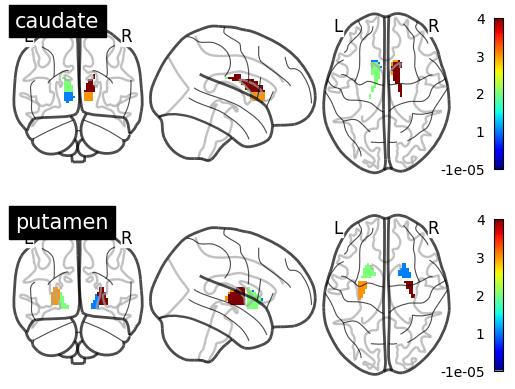

In [12]:
fig, axs = plt.subplots(nrows=2)

imgs = {}
for ii, roi in enumerate(['caudate','putamen']):
    ax = axs[ii]
    imgs[roi] = image.load_img(
        join(dir_mask,'mask.TTatlas.%s.resampled.nii'%roi),
    )
    plotting.plot_glass_brain(
        imgs[roi],
        title=roi,
        cmap=cm.jet, colorbar=True,
        axes=ax
    )

putamen: ra=1, la=2, lp=3, rp=4 \
caudate: la=1, lp=2, ra=3, rp=4

In [13]:
# dict_roi = {}
# ## Putamen
# dict_roi['raPU'] = 1
# dict_roi['laPU'] = 2
# dict_roi['lpPU'] = 3
# dict_roi['rpPU'] = 4
# ## Caudate
# dict_roi['laCA'] = 1
# dict_roi['lpCA'] = 2
# dict_roi['raCA'] = 3
# dict_roi['rpCA'] = 4

---

## 1. Fig. S1A

In [14]:
img_mask = image.math_img(
    img1=imgs['putamen'], img2=imgs['caudate'],
    formula='img1 + (img2+4)*(img2>0)'
)

/home/sungbeenpark/anaconda3/envs/GP/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



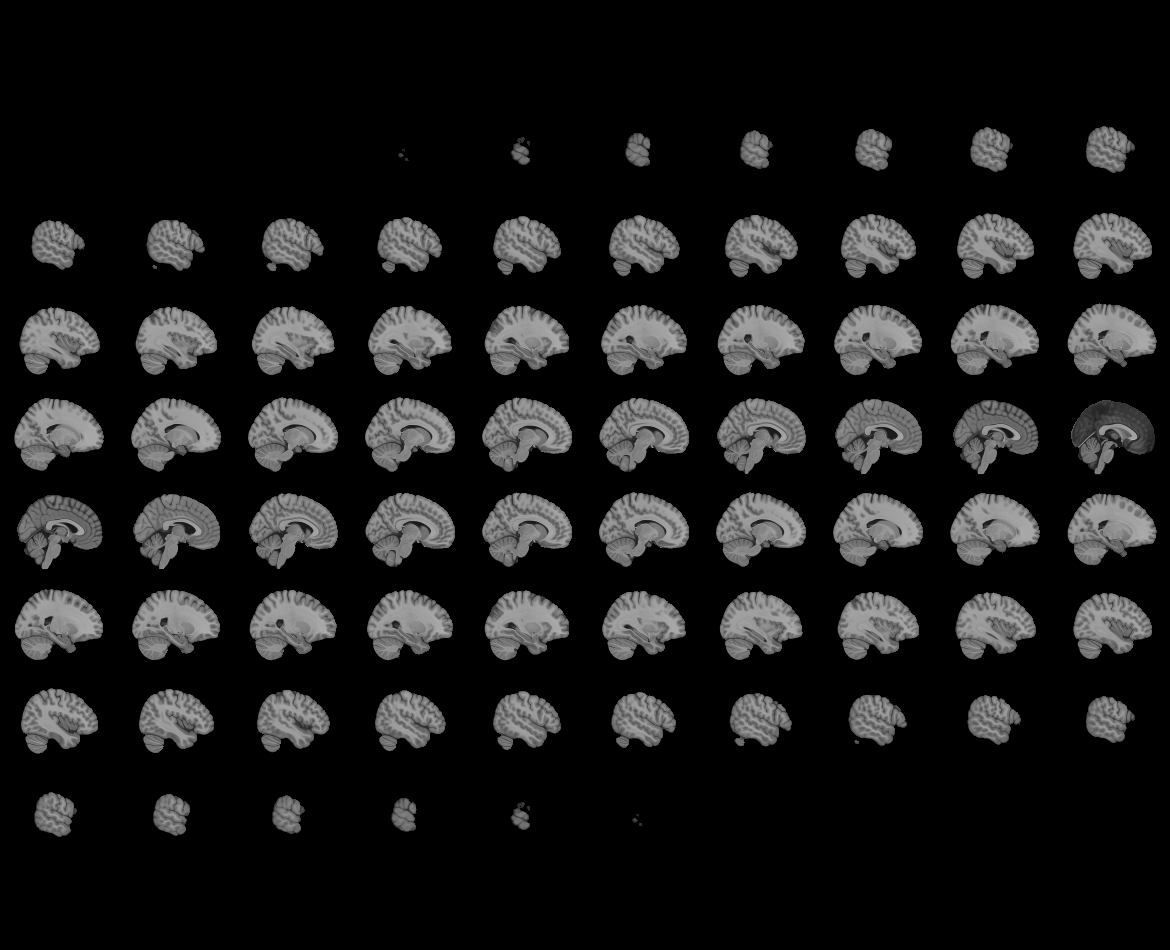
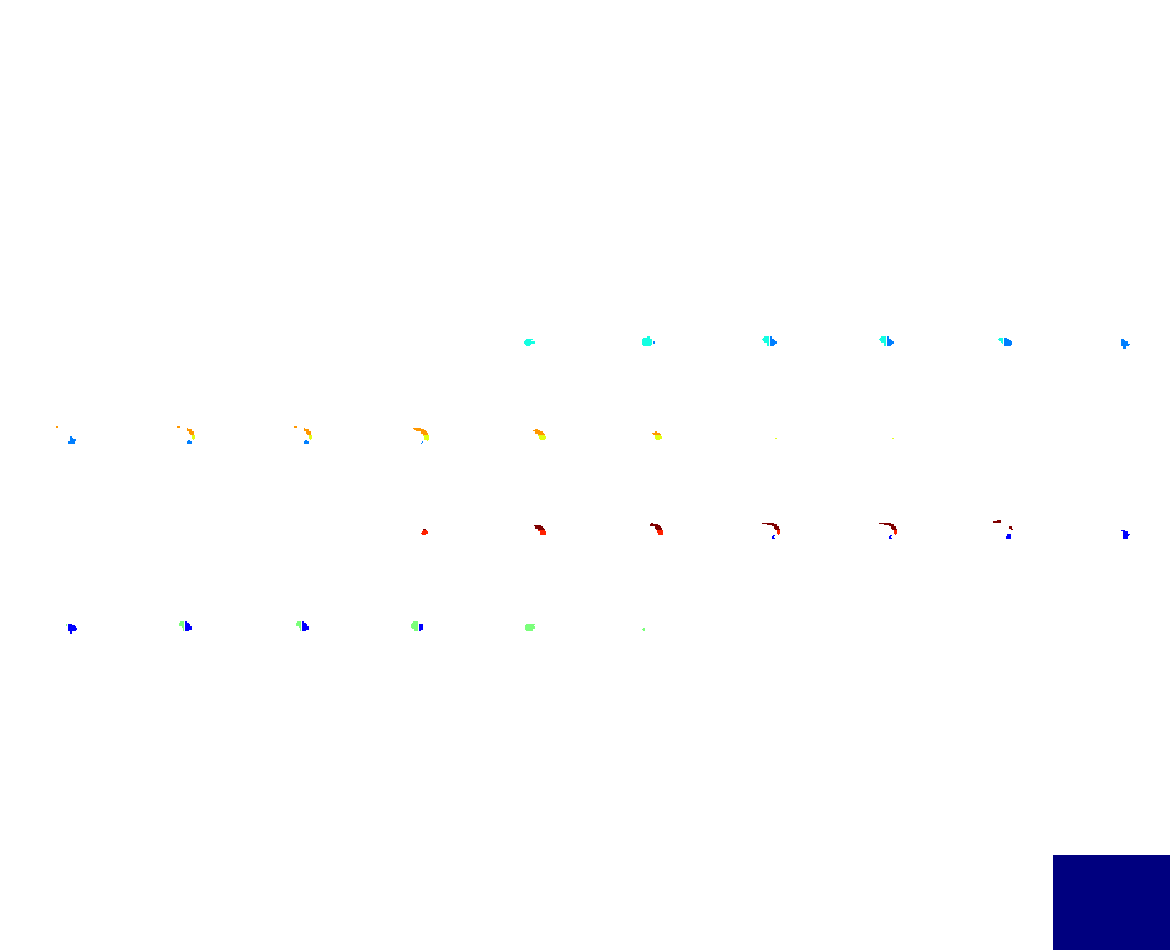

In [15]:
plotting.view_img(
    img_mask,
    cmap=cm.jet.resampled(9), colorbar=True, symmetric_cmap=False,
    resampling_interpolation='nearest'
)

In [16]:
changed_idx = []
tmp = list_label[1:]
for i in range(8):
    if tmp[i] != list_roi[i]:
        changed_idx.append((i,list_roi.index(tmp[i])))
changed_idx

[(0, 5), (1, 4), (2, 6), (3, 7), (4, 0), (5, 2), (6, 1), (7, 3)]

In [17]:
palette = sns.color_palette("hls", len(list_roi))
palette

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

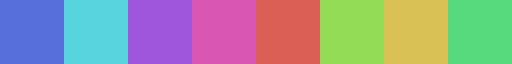

In [18]:
tmp = []
for (i,j) in changed_idx:
    tmp.append(palette[j])
palette = sns.color_palette(tmp)
cmap = colors.ListedColormap(palette)
cmap

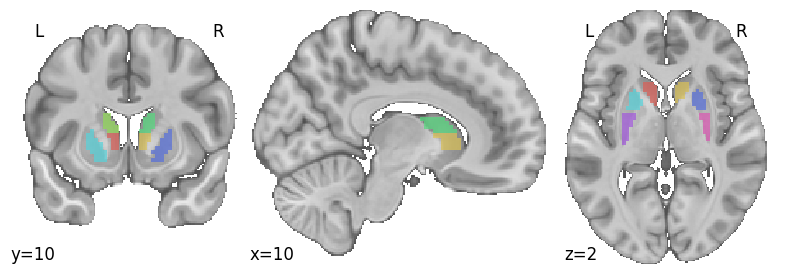

In [19]:
fig, ax = plt.subplots(figsize=(10, 3.3)) 

plotting.plot_roi(
    img_mask, black_bg=False,
    bg_img=img_bg,
    display_mode='ortho', draw_cross=False,
    cut_coords=(10, 10, 2),  # Adjust these coordinates based on your needs
    # view_type='contours', linewidths=2.5,
    cmap=cmap,
    axes = ax
)

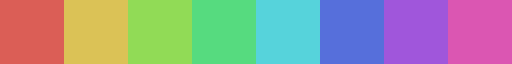

In [20]:
palette = sns.color_palette("hls", len(list_roi))
cmap = colors.ListedColormap(palette)
cmap

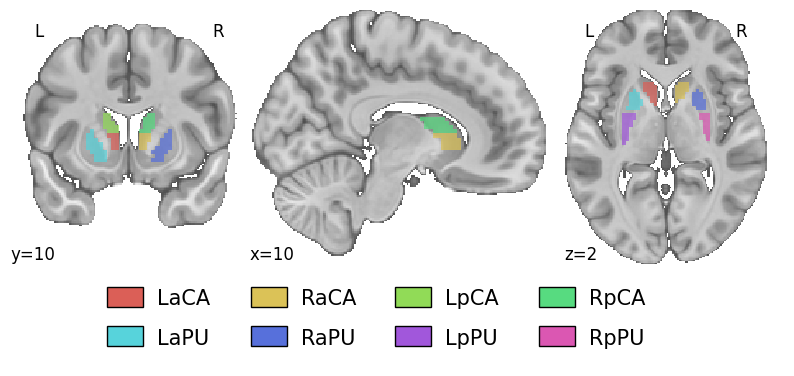

In [21]:
### legend
nax = fig.add_axes([0.15, -0.2, 0.72, 0.3])

# list_color = np.round(np.linspace(0, cmap.N-1, 4)).astype(int)

for ii, roi in enumerate(list_roi):
        
    rgb = cmap(ii)
    dx = 0.2
    dy = 0.4
    x, y = 0.1 + dx*(ii%4), 0.6 - dy*(ii//4)
    w, h = 0.05, 0.2
    nax.add_patch(Rectangle((x,y),w , h, facecolor=rgb, edgecolor='k'))
    nax.text(x+.07, y-0.02, roi, fontsize=15, horizontalalignment='left', verticalalignment='bottom')
    
nax.axis('off')
fig

In [22]:
# fig.savefig(
#     '/home/sungbeenpark/Github/labs/GP/results/fig.S1a.png'
#     , dpi=300, facecolor=[1,1,1,1]
#     , bbox_inches = "tight"
# )

---

2. (Left) Anterior vs. Posterior

In [23]:
# img_mask = image.math_img(
#     img1=imgs['putamen'], img2=imgs['caudate'],
#     formula='(img1==%d)+(img2==%d) + ((img1==%d)+(img2==%d))*2'\
#     %(dict_roi['laPU'],dict_roi['laCA'],dict_roi['lpPU'],dict_roi['lpCA'])
# )

In [24]:
# plotting.plot_glass_brain(
#     img_mask,
#     cmap=cm.jet.resampled(10), colorbar=True,
# )

In [25]:
# list_label = ['laST', 'lpST']

---

3. (Left) Putamen vs. Caudate

In [26]:
# img_mask = image.math_img(
#     img1=imgs['putamen'], img2=imgs['caudate'],
#     formula='(img1==%d)+(img1==%d) + ((img2==%d)+(img2==%d))*2'\
#     %(dict_roi['laPU'],dict_roi['lpPU'],dict_roi['laCA'],dict_roi['lpCA'])
# )

In [27]:
# plotting.plot_glass_brain(
#     img_mask,
#     cmap=cm.jet.resampled(10), colorbar=True,
# )

In [28]:
# list_label = ['lPU', 'lCA']

---

In [29]:
dict_nvoxels = {}
tmp = img_mask.get_fdata().astype(int)
for ii, l in enumerate(list_label):
    dict_nvoxels[l] = len(tmp[tmp==ii])
dict_nvoxels

{'rest': 544614,
 'RaPU': 135,
 'LaPU': 133,
 'LpPU': 132,
 'RpPU': 105,
 'LaCA': 71,
 'LpCA': 103,
 'RaCA': 66,
 'RpCA': 109}

In [30]:
masker = NiftiLabelsMasker(
    labels_img=img_mask, labels=list_label,
    memory='/home/sungbeenpark/trash/nilearn_cache', verbose=0
)

---

In [31]:
# p_thresh = 5.e-2
# thresh = stats.norm.isf(0.5*p_thresh)

In [32]:
# run='r01'

In [33]:
# group = 'DLPFC_cTBS'
# fname_Zscr = glob(join(dir_stat,'Zstat.%s.%s.n??.nii'%(run,group)))[0]
# plotting.view_img(
#     fname_Zscr
#     , threshold=thresh
# )

---

In [34]:
prop = 'Rew#1_Coef'

In [35]:
df = pd.DataFrame()

for run in list_run:
    print(run)
    
    ## GA
    a = sorted(glob(join(
            '/mnt/ext5/GA/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted'
            , 'GA??/%s.%s.GA??.nii'%(prop,run)
        )))
    ## GP
    p = sorted(glob(join(dir_stat,'GP??/%s.%s.GP??.nii'%(prop,run))))
    
    ## combining these as whole data set
    list_fname = np.concatenate([a,p])

    for fname in tqdm(list_fname):
        subj = fname.split('/')[-2]
        nn=subj[2:]

        group = dz.loc[subj,'group']

#         beta = masking.apply_mask(imgs=fname, mask_img=img)
        betas = masker.fit_transform(fname)[0]
        for ii, roi in enumerate(list_label[1:]):
            new_row = pd.Series(
                {
                    'subj':subj, 'group':group, 'run':run,
                    'roi':roi,
#                     'lr':roi[0], 'ap':roi[1], 'anat':roi[2:],
                    'beta':betas[ii],
                    'nvoxels':dict_nvoxels[roi]
                }
            )
            df = pd.concat(
                [df, new_row.to_frame().T]
                , axis='index'
                , ignore_index=True
            )
# df.set_index('subj', inplace=True)
# df.index.name = None

r01


100%|██████████| 80/80 [00:02<00:00, 35.22it/s]


r02


100%|██████████| 80/80 [00:02<00:00, 36.38it/s]


r03


100%|██████████| 80/80 [00:02<00:00, 35.94it/s]


In [36]:
df = df.astype({'beta':float, 'nvoxels':int})
# df['beta_sum'] = df.beta*df.nvoxels
df

,subj,group,run,roi,beta,nvoxels
0,GA01,no_stim,r01,RaPU,0.518611,135
1,GA01,no_stim,r01,LaPU,0.599993,133
2,GA01,no_stim,r01,LpPU,0.151185,132
3,GA01,no_stim,r01,RpPU,0.272298,105
4,GA01,no_stim,r01,LaCA,0.538827,71
...,...,...,...,...,...,...
1915,GP75,DLPFC_20Hz,r03,RpPU,0.614432,105
1916,GP75,DLPFC_20Hz,r03,LaCA,0.917109,71
1917,GP75,DLPFC_20Hz,r03,LpCA,0.538714,103
1918,GP75,DLPFC_20Hz,r03,RaCA,1.086447,66


In [37]:
df.to_excel('/home/sungbeenpark/Github/labs/GP/results/performance_modulated_activity.8_striatum.xlsx', index=False)

---
---

## Load the DataFrame `df`

In [3]:
fname = '/home/sungbeenpark/github/GloveProject_TMS/results/Rew#1_Coef.xlsx'
df = pd.read_excel(fname)
df

,subj,group,run,roi,beta,nvoxels
0,GA01,no_stim,r01,RaPU,0.518611,135
1,GA01,no_stim,r01,LaPU,0.599993,133
2,GA01,no_stim,r01,LpPU,0.151185,132
3,GA01,no_stim,r01,RpPU,0.272298,105
4,GA01,no_stim,r01,LaCA,0.538827,71
...,...,...,...,...,...,...
1915,GP75,DLPFC_20Hz,r03,RpPU,0.614432,105
1916,GP75,DLPFC_20Hz,r03,LaCA,0.917109,71
1917,GP75,DLPFC_20Hz,r03,LpCA,0.538714,103
1918,GP75,DLPFC_20Hz,r03,RaCA,1.086447,66


### i) Two-way (group x ROI) rm ANOVA

In [10]:
result_anova = pg.anova(
    data=df[df.run=='r01'],
    dv='beta', between=['group','roi'],
    detailed=True, effsize="np2"
)
print(result_anova)

        Source         SS     DF        MS          F         p-unc       np2
0        group   0.674481    3.0  0.224827   2.556875  5.433738e-02  0.012459
1          roi   8.803347    7.0  1.257621  14.302456  2.912651e-17  0.141385
2  group * roi   0.452382   21.0  0.021542   0.244989  9.998167e-01  0.008391
3     Residual  53.461696  608.0  0.087930        NaN           NaN       NaN


-> 10 min 에서는 그룹 간의 차이가 없음

### ii) $\beta$ difference over time 

In [11]:
df_tmp = df[df.run.isin(['r01','r03'])]
pivot = df_tmp.pivot_table(index=['subj', 'group', 'roi'], columns='run', values='beta').reset_index(drop=False)
pivot['beta_diff'] = pivot['r03'] - pivot['r01']
pivot

run,subj,group,roi,r01,r03,beta_diff
0,GA01,no_stim,LaCA,0.538827,-0.087391,-0.626218
1,GA01,no_stim,LaPU,0.599993,-0.137885,-0.737878
2,GA01,no_stim,LpCA,0.573242,-0.625521,-1.198764
3,GA01,no_stim,LpPU,0.151185,-0.623068,-0.774253
4,GA01,no_stim,RaCA,0.612334,-0.252511,-0.864844
...,...,...,...,...,...,...
635,GP75,DLPFC_20Hz,LpPU,0.713161,0.485856,-0.227304
636,GP75,DLPFC_20Hz,RaCA,1.177611,1.086447,-0.091163
637,GP75,DLPFC_20Hz,RaPU,1.116773,0.862148,-0.254625
638,GP75,DLPFC_20Hz,RpCA,1.084892,0.616211,-0.468681


In [15]:
result_anova = pg.anova(
    data=pivot,
    dv='beta_diff', between=['group','roi'],
    detailed=True, effsize="np2"
)
print(result_anova)

        Source         SS     DF        MS          F         p-unc       np2
0        group   8.230508    3.0  2.743503  26.796725  2.743783e-16  0.116780
1          roi   1.541885    7.0  0.220269   2.151446  3.680771e-02  0.024171
2  group * roi   1.571387   21.0  0.074828   0.730870  8.027091e-01  0.024622
3     Residual  62.248262  608.0  0.102382        NaN           NaN       NaN


In [22]:
list_group = ['no_stim', 'DLPFC_cTBS', 'M1_cTBS', 'DLPFC_20Hz']
list_roi = sorted(df.roi.unique())

In [23]:
g1 = 'no_stim'
for g2 in list_group[1:]:
    print('%s vs. %s'%(g1,g2))
    for roi in list_roi:
        a = pivot[(pivot.roi==roi)&(pivot.group==g1)].beta_diff
        b = pivot[(pivot.roi==roi)&(pivot.group==g2)].beta_diff

        # Perform an independent t-test
        res = stats.ttest_ind(a, b)
        tval, pval = res
        dof = res.df
        ## Bonferroni correction
        pval_c = pval * 8
    
        print('%s: t(%d)=%.2f (%sp=%.5f; corrected %sp=%.5f)'%
            (roi,dof,tval,convert_pvalue_to_asterisks(pval),pval,convert_pvalue_to_asterisks(pval_c),pval_c)
        )
    print('')

no_stim vs. DLPFC_cTBS
LaCA: t(45)=3.22 (**p=0.00236; corrected *p=0.01892)
LaPU: t(45)=1.43 (nsp=0.15973; corrected nsp=1.27784)
LpCA: t(45)=1.49 (nsp=0.14230; corrected nsp=1.13842)
LpPU: t(45)=0.08 (nsp=0.93820; corrected nsp=7.50559)
RaCA: t(45)=2.55 (*p=0.01425; corrected nsp=0.11396)
RaPU: t(45)=2.26 (*p=0.02892; corrected nsp=0.23136)
RpCA: t(45)=2.37 (*p=0.02237; corrected nsp=0.17892)
RpPU: t(45)=-0.03 (nsp=0.98015; corrected nsp=7.84123)

no_stim vs. M1_cTBS
LaCA: t(45)=-0.24 (nsp=0.80965; corrected nsp=6.47718)
LaPU: t(45)=-0.93 (nsp=0.35617; corrected nsp=2.84935)
LpCA: t(45)=-1.03 (nsp=0.30776; corrected nsp=2.46205)
LpPU: t(45)=-1.32 (nsp=0.19490; corrected nsp=1.55918)
RaCA: t(45)=-0.51 (nsp=0.61500; corrected nsp=4.92001)
RaPU: t(45)=-0.16 (nsp=0.87205; corrected nsp=6.97644)
RpCA: t(45)=-1.06 (nsp=0.29554; corrected nsp=2.36431)
RpPU: t(45)=-1.10 (nsp=0.27696; corrected nsp=2.21571)

no_stim vs. DLPFC_20Hz
LaCA: t(44)=-0.85 (nsp=0.39925; corrected nsp=3.19402)
LaPU: t(

---
---

## Fig. 3C_1

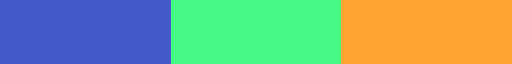

In [39]:
tmp = cm.turbo(np.linspace(0.1,1.0,4))
palette = [colors.rgb2hex(rgb, keep_alpha=False) for rgb in tmp][:-1]

colors.ListedColormap(palette)

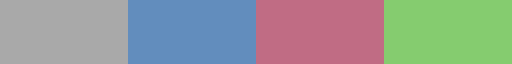

In [40]:
palette = ['#A9A9A9', '#628dbd', '#C06C84', '#85cc6f']
cmap = colors.ListedColormap(palette)
cmap

In [41]:
hue_order = ['no_stim','DLPFC_cTBS','M1_cTBS']

# n_Bonferroni = len(list_roi)*len(list_run)*len(hue_order)
n_Bonferroni = len(list_roi)*2 # 2 means 'no_stim vs. DLPFC_cTBS' or 'no_stim vs. M1_cTBS'
n_Bonferroni

16

LaCA
r01
r02
r03
no_stim vs DLPFC_cTBS : t(45)=2.072 (*p=0.04401 uncorrected / nsp=0.70414 corrected)
DLPFC_cTBS vs M1_cTBS : t(32)=-2.273 (*p=0.02988 uncorrected / nsp=0.47803 corrected)

RaCA
r01
r02
DLPFC_cTBS vs M1_cTBS : t(32)=-2.278 (*p=0.02955 uncorrected / nsp=0.47277 corrected)
r03
no_stim vs DLPFC_cTBS : t(45)=2.320 (*p=0.02495 uncorrected / nsp=0.39916 corrected)
DLPFC_cTBS vs M1_cTBS : t(32)=-2.385 (*p=0.02317 uncorrected / nsp=0.37072 corrected)

LpCA
r01
r02
r03

RpCA
r01
r02
r03
no_stim vs DLPFC_cTBS : t(45)=2.043 (*p=0.04694 uncorrected / nsp=0.75107 corrected)
DLPFC_cTBS vs M1_cTBS : t(32)=-2.097 (*p=0.04397 uncorrected / nsp=0.70346 corrected)

LaPU
r01
r02
DLPFC_cTBS vs M1_cTBS : t(32)=-2.359 (*p=0.02461 uncorrected / nsp=0.39379 corrected)
r03
DLPFC_cTBS vs M1_cTBS : t(32)=-2.191 (*p=0.03584 uncorrected / nsp=0.57340 corrected)

RaPU
r01
r02
r03
no_stim vs DLPFC_cTBS : t(45)=2.030 (*p=0.04826 uncorrected / nsp=0.77213 corrected)

LpPU
r01
r02
r03

RpPU
r01
r02
r03



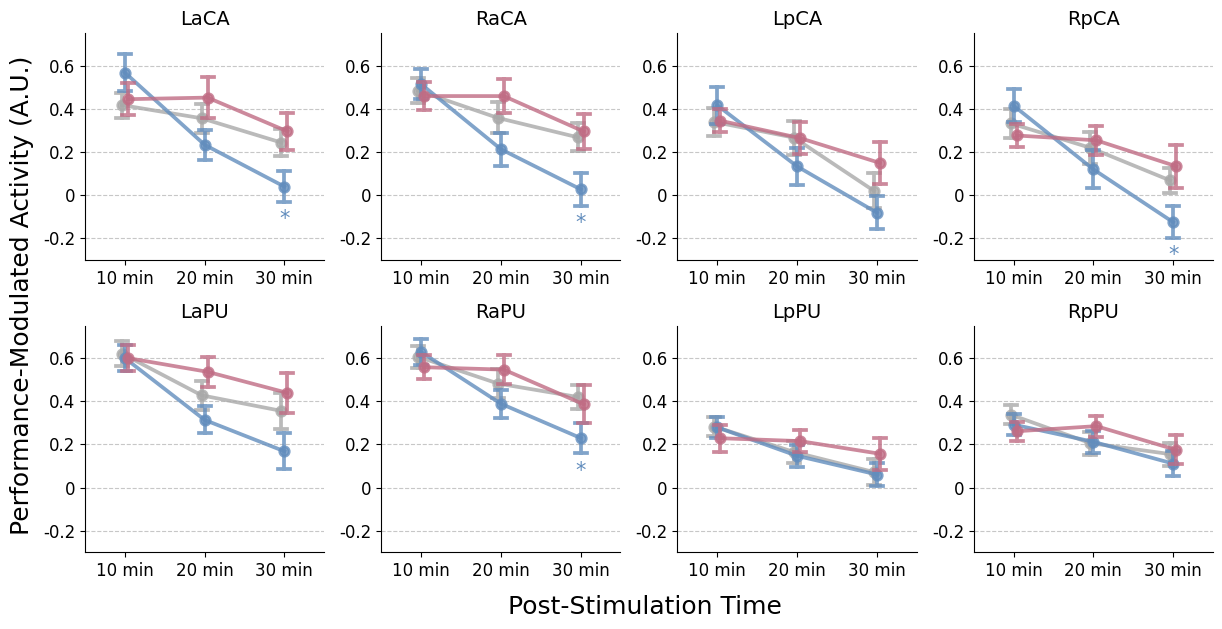

In [42]:
ncols, nrows = 4, 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols,3*nrows))
axs = np.concatenate(axs)

for ii, roi in enumerate(list_roi):
    ax = axs[ii]
    g = sns.pointplot(
        data=df[df.roi==roi], x='run', y='beta', hue='group',
        order=list_run, hue_order=hue_order, palette=palette[:len(hue_order)],
        errorbar='se', capsize=0.15,
        dodge=True, alpha=0.8,
        ax=ax
    )
    ## significant signs
    
    ax.set_title(roi, fontsize=14, loc='center')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend().remove()
    
    ax.set_ylim(-0.3,0.75)
    ax.set_ylabel('', fontsize=0)
    ax.set_yticks([-0.2, 0, 0.2, 0.4, 0.6])
    ax.set_yticklabels([-0.2, 0, 0.2, 0.4, 0.6], fontsize=12)
    
    ax.set_xlabel('', fontsize=0)
    ax.set_xticks(list_run)
    ax.set_xticklabels(['10 min', '20 min', '30 min'], fontsize=12)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    print(roi)
    for kk, run in enumerate(list_run):
        print(run)
        for ii, g1 in enumerate(hue_order):
            for jj, g2 in enumerate(hue_order[ii+1:]):
                a = df[(df.group==g1)&(df.run==run)&(df.roi==roi)].beta.astype(float)
                b = df[(df.group==g2)&(df.run==run)&(df.roi==roi)].beta.astype(float)
                res = stats.ttest_ind(a,b)
                tval, pval = res
                dof = res.df
                ## Bonferroni correction
                pval_c = pval * n_Bonferroni

                if pval < 0.05:
                    print('%s vs %s : t(%d)=%.3f (%sp=%.5f uncorrected / %sp=%.5f corrected)'%
                        (g1,g2,dof,tval,convert_pvalue_to_asterisks(pval),pval,convert_pvalue_to_asterisks(pval_c),pval_c)
                    )
                    if (g1 == 'no_stim') and (g2 == 'DLPFC_cTBS'):
                        x0 = kk
                        color = palette[1]
                        alpha = 1
                    elif (g1 == 'no_stim') and (g2 == 'M1_cTBS'):
                        x0 = kk + 0.035
                        color = palette[2]
                        alpha = 1
                    else:
                        alpha = 0
                    if b.mean() > a.mean():
                        y0 = b.mean()+b.sem()+0.05
                    else:
                        y0 = b.mean()-b.sem()-0.08
                    g.text(
                        x0, y0, convert_pvalue_to_asterisks(pval),
                        ha='center', va='center', rotation=0, size=15,
                        color=color, alpha=alpha
                    )
    print('')

fig.text(-.015, 0.5, 'Performance-Modulated Activity (A.U.)', va='center', rotation='vertical', fontsize=18)
fig.text(0.4, -0.02, 'Post-Stimulation Time', va='center', rotation='horizontal', fontsize=18)

fig.tight_layout()

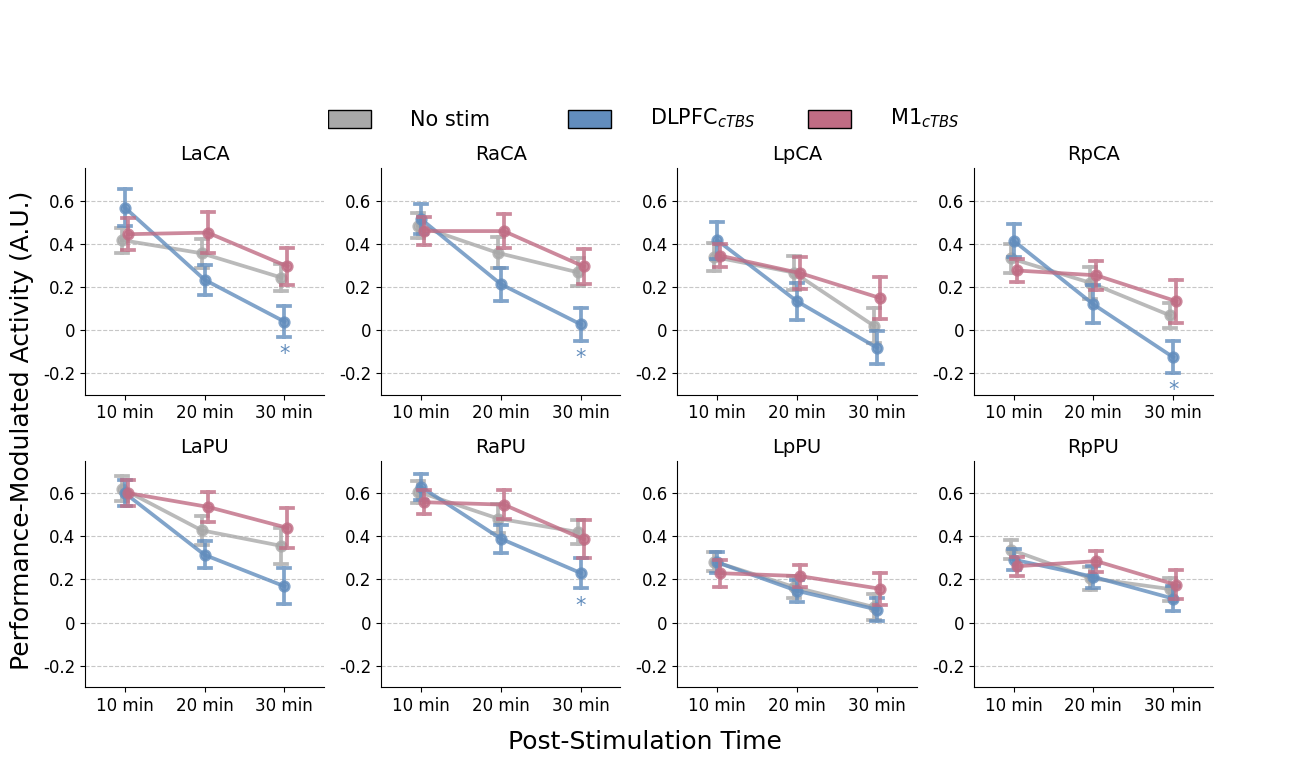

In [43]:
### legend
nax = fig.add_axes([0.25, 1, .8, 0.2])

# list_color = np.round(np.linspace(0, cmap.N-1, 4)).astype(int)

for ii, group in enumerate(hue_order):
    if group == 'no_stim':
        gg = 'No stim'
    elif group == 'DLPFC_cTBS':
        gg = 'DLPFC$_{cTBS}$'
    elif group == 'M1_cTBS':
        gg = 'M1$_{cTBS}$'
        
    rgb = cmap(ii)
    dx = 0.25*ii
    x, y = 0 + dx, 0.02
    w, h = 0.045, 0.15
    nax.add_patch(Rectangle((x,y),w , h, facecolor=rgb, edgecolor='k'))
    nax.text(x+.085, 0, gg, fontsize=15, horizontalalignment='left', verticalalignment='bottom')
    
nax.axis('off')
fig

In [44]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fig.3c.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

---

## Statistics

### 1. T-test

In [26]:
df_tmp = df[df.run.isin(['r01','r03'])]
pivot = df_tmp.pivot_table(index=['subj', 'group', 'roi'], columns='run', values='beta').reset_index(drop=False)
pivot['beta_diff'] = pivot['r03'] - pivot['r01']
pivot

run,subj,group,roi,r01,r03,beta_diff
0,GA01,no_stim,LaCA,0.538827,-0.087391,-0.626218
1,GA01,no_stim,LaPU,0.599993,-0.137885,-0.737878
2,GA01,no_stim,LpCA,0.573242,-0.625521,-1.198764
3,GA01,no_stim,LpPU,0.151185,-0.623068,-0.774253
4,GA01,no_stim,RaCA,0.612334,-0.252511,-0.864844
...,...,...,...,...,...,...
635,GP75,DLPFC_20Hz,LpPU,0.713161,0.485856,-0.227304
636,GP75,DLPFC_20Hz,RaCA,1.177611,1.086447,-0.091163
637,GP75,DLPFC_20Hz,RaPU,1.116773,0.862148,-0.254625
638,GP75,DLPFC_20Hz,RpCA,1.084892,0.616211,-0.468681


In [27]:
anterior = ['LaCA','RaCA','LaPU','RaPU']
caudate = ['LaCA','RaCA','LpCA','RpCA']
list_ = list_roi
# list_ = caudate

In [28]:
n_Bonferroni = len(list_)
# n_Bonferroni = len(anterior)
n_Bonferroni

8

In [32]:
for ii, g1 in enumerate(['no_stim', 'DLPFC_cTBS']):
    for g2 in list_group[ii+1:]:
        print('%s vs. %s'%(g1,g2))
        for roi in list_:
            a = pivot[(pivot.roi==roi)&(pivot.group==g1)].beta_diff
            b = pivot[(pivot.roi==roi)&(pivot.group==g2)].beta_diff
        
            # Perform an independent t-test
            res = stats.ttest_ind(a, b)
            tval, pval = res
            dof = res.df
            ## Bonferroni correction
            pval_c = pval * n_Bonferroni
        
            print('%s: t(%d)=%.2f (%sp=%.5f; corrected %sp=%.5f)'%
                (roi,dof,tval,convert_pvalue_to_asterisks(pval),pval,convert_pvalue_to_asterisks(pval_c),pval_c)
            )
        print('')

no_stim vs. DLPFC_cTBS
LaCA: t(45)=3.22 (**p=0.00236; corrected *p=0.01892)
RaCA: t(45)=2.55 (*p=0.01425; corrected nsp=0.11396)
LpCA: t(45)=1.49 (nsp=0.14230; corrected nsp=1.13842)
RpCA: t(45)=2.37 (*p=0.02237; corrected nsp=0.17892)
LaPU: t(45)=1.43 (nsp=0.15973; corrected nsp=1.27784)
RaPU: t(45)=2.26 (*p=0.02892; corrected nsp=0.23136)
LpPU: t(45)=0.08 (nsp=0.93820; corrected nsp=7.50559)
RpPU: t(45)=-0.03 (nsp=0.98015; corrected nsp=7.84123)

no_stim vs. M1_cTBS
LaCA: t(45)=-0.24 (nsp=0.80965; corrected nsp=6.47718)
RaCA: t(45)=-0.51 (nsp=0.61500; corrected nsp=4.92001)
LpCA: t(45)=-1.03 (nsp=0.30776; corrected nsp=2.46205)
RpCA: t(45)=-1.06 (nsp=0.29554; corrected nsp=2.36431)
LaPU: t(45)=-0.93 (nsp=0.35617; corrected nsp=2.84935)
RaPU: t(45)=-0.16 (nsp=0.87205; corrected nsp=6.97644)
LpPU: t(45)=-1.32 (nsp=0.19490; corrected nsp=1.55918)
RpPU: t(45)=-1.10 (nsp=0.27696; corrected nsp=2.21571)

no_stim vs. DLPFC_20Hz
LaCA: t(44)=-0.85 (nsp=0.39925; corrected nsp=3.19402)
RaCA: t(

### 2. Two-way ANOVA

In [44]:
result_anova = pg.anova(
    data=df[df.run=='r03'],
    dv='beta', between=['group', 'roi'],
    detailed=True, effsize="np2"
)
print(result_anova)

        Source         SS     DF        MS          F         p-unc       np2
0        group   4.308334    3.0  1.436111  12.434067  6.687697e-08  0.057806
1          roi   7.734266    7.0  1.104895   9.566348  2.636782e-11  0.099212
2  group * roi   1.022659   21.0  0.048698   0.421635  9.897750e-01  0.014354
3     Residual  70.222857  608.0  0.115498        NaN           NaN       NaN


In [50]:
for roi in list_roi:
    print(roi)
    result_anova = pg.anova(
        data=df[(df.run=='r01')&(df.roi==roi)&(df.group.isin(hue_order))],
        dv='beta', between=['group'],
        detailed=False, effsize="np2"
    )
    print(result_anova)
    print('')

LaCA
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     61  1.216573  0.303329  0.038358

RaCA
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     61  0.147608  0.863077  0.004816

LpCA
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     61  0.339899  0.713182  0.011021

RpCA
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     61  0.782798  0.461663  0.025023

LaPU
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     61  0.044343  0.956657  0.001452

RaPU
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     61  0.334716  0.716847  0.010855

LpPU
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     61  0.323626  0.724755  0.010499

RpPU
  Source  ddof1  ddof2        F     p-unc       np2
0  group      2     61  0.72749  0.487264  0.023296



---

## Fig. S2

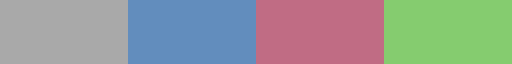

In [38]:
palette = ['#A9A9A9', '#628dbd', '#C06C84', '#85cc6f']
# palette = ['#A9A9A9', '#628dbd', '#85cc6f']
cmap = colors.ListedColormap(palette)
cmap

In [39]:
hue_order = ['no_stim','DLPFC_cTBS','M1_cTBS','DLPFC_20Hz']
# hue_order = ['no_stim','DLPFC_cTBS','DLPFC_20Hz']

# n_Bonferroni = len(list_roi)*len(list_run)*len(hue_order)
n_Bonferroni = len(list_roi)*2 # 2 means 'no_stim vs. DLPFC_cTBS' or 'no_stim vs. DLPFC_20Hz'
n_Bonferroni

16

LaCA
r01
r02
r03
no_stim vs DLPFC_cTBS : t(45)=2.072 (*p=0.04401 uncorrected / nsp=0.70414 corrected)
DLPFC_cTBS vs M1_cTBS : t(32)=-2.273 (*p=0.02988 uncorrected / nsp=0.47803 corrected)
DLPFC_cTBS vs DLPFC_20Hz : t(31)=-2.348 (*p=0.02546 uncorrected / nsp=0.40731 corrected)

RaCA
r01
r02
DLPFC_cTBS vs M1_cTBS : t(32)=-2.278 (*p=0.02955 uncorrected / nsp=0.47277 corrected)
r03
no_stim vs DLPFC_cTBS : t(45)=2.320 (*p=0.02495 uncorrected / nsp=0.39916 corrected)
DLPFC_cTBS vs M1_cTBS : t(32)=-2.385 (*p=0.02317 uncorrected / nsp=0.37072 corrected)
DLPFC_cTBS vs DLPFC_20Hz : t(31)=-2.334 (*p=0.02625 uncorrected / nsp=0.42004 corrected)

LpCA
r01
r02
r03
DLPFC_cTBS vs DLPFC_20Hz : t(31)=-2.608 (*p=0.01389 uncorrected / nsp=0.22228 corrected)

RpCA
r01
r02
r03
no_stim vs DLPFC_cTBS : t(45)=2.043 (*p=0.04694 uncorrected / nsp=0.75107 corrected)
DLPFC_cTBS vs M1_cTBS : t(32)=-2.097 (*p=0.04397 uncorrected / nsp=0.70346 corrected)
DLPFC_cTBS vs DLPFC_20Hz : t(31)=-3.177 (**p=0.00336 uncorrecte

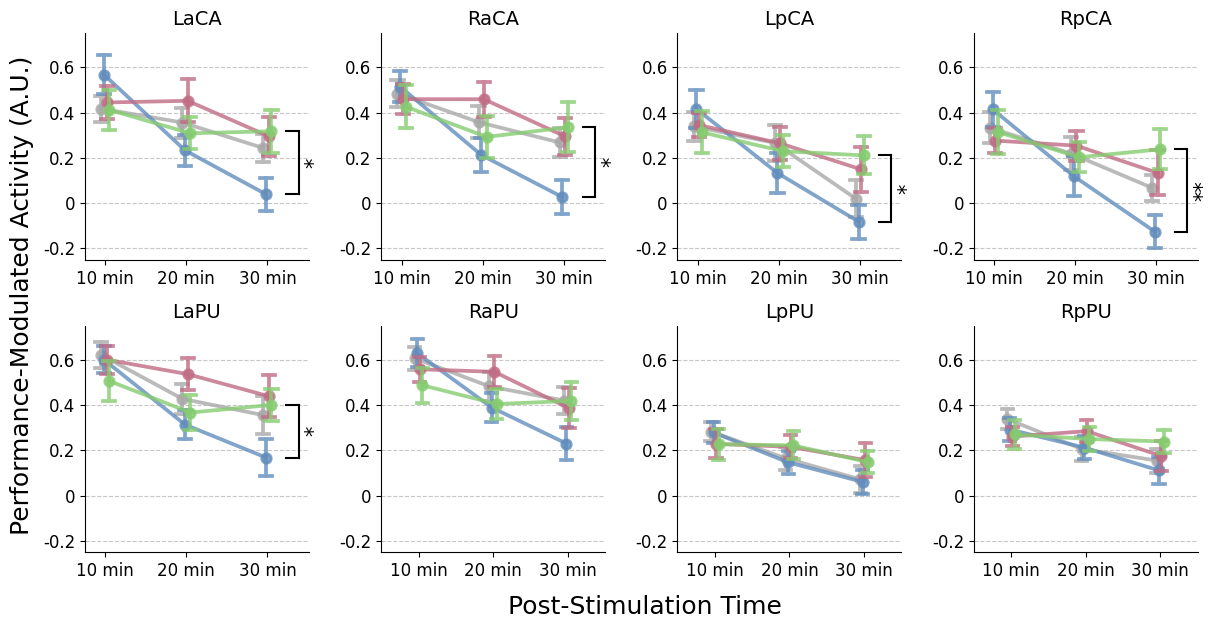

In [40]:
ncols, nrows = 4, 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols,3*nrows))
axs = np.concatenate(axs)

for ii, roi in enumerate(list_roi):
    ax = axs[ii]
    g = sns.pointplot(
        data=df[df.roi==roi], x='run', y='beta', hue='group',
        order=list_run, hue_order=hue_order, palette=palette[:len(hue_order)],
        errorbar='se', capsize=0.15,
        dodge=True, alpha=0.8,
        ax=ax
    )
    ax.set_title(roi, fontsize=14, loc='center')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend().remove()
    
    ax.set_ylim(-0.25,0.75)
    ax.set_ylabel('', fontsize=0)
    ax.set_yticks([-0.2, 0, 0.2, 0.4, 0.6])
    ax.set_yticklabels([-0.2, 0, 0.2, 0.4, 0.6], fontsize=12)
    
    ax.set_xlabel('', fontsize=0)
    ax.set_xticks(list_run)
    ax.set_xticklabels(['10 min', '20 min', '30 min'], fontsize=12)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    print(roi)
    for kk, run in enumerate(list_run):
        print(run)
        for ii, g1 in enumerate(hue_order):
            for jj, g2 in enumerate(hue_order[ii+1:]):
                a = df[(df.group==g1)&(df.run==run)&(df.roi==roi)].beta.astype(float)
                b = df[(df.group==g2)&(df.run==run)&(df.roi==roi)].beta.astype(float)
                res = stats.ttest_ind(a,b)
                tval, pval = res
                dof = res.df
                ## Bonferroni correction
                pval_c = pval * n_Bonferroni

                if pval < 0.05:
                    print('%s vs %s : t(%d)=%.3f (%sp=%.5f uncorrected / %sp=%.5f corrected)'%
                        (g1,g2,dof,tval,convert_pvalue_to_asterisks(pval),pval,convert_pvalue_to_asterisks(pval_c),pval_c)
                    )
                    if g1 == 'DLPFC_cTBS' and g2 == 'DLPFC_20Hz':
                        x1 = kk + 0.035 + 0.2
                        x2 = x1 + 0.15
                        y1 = a.mean()
                        y2 = b.mean()
                        g.plot([x1, x2], [y1, y1], 'k-')
                        g.plot([x1, x2], [y2, y2], 'k-')
                        g.plot([x2, x2], [y1, y2], 'k-')
                        g.text(
                            x2+0.2, (y1+y2)*0.5, convert_pvalue_to_asterisks(pval),
                            ha='center', va='center', rotation=90, size=15,
                            color='k'
                        )
    print('')

fig.text(-.015, 0.5, 'Performance-Modulated Activity (A.U.)', va='center', rotation='vertical', fontsize=18)
fig.text(0.4, -0.02, 'Post-Stimulation Time', va='center', rotation='horizontal', fontsize=18)

fig.tight_layout()

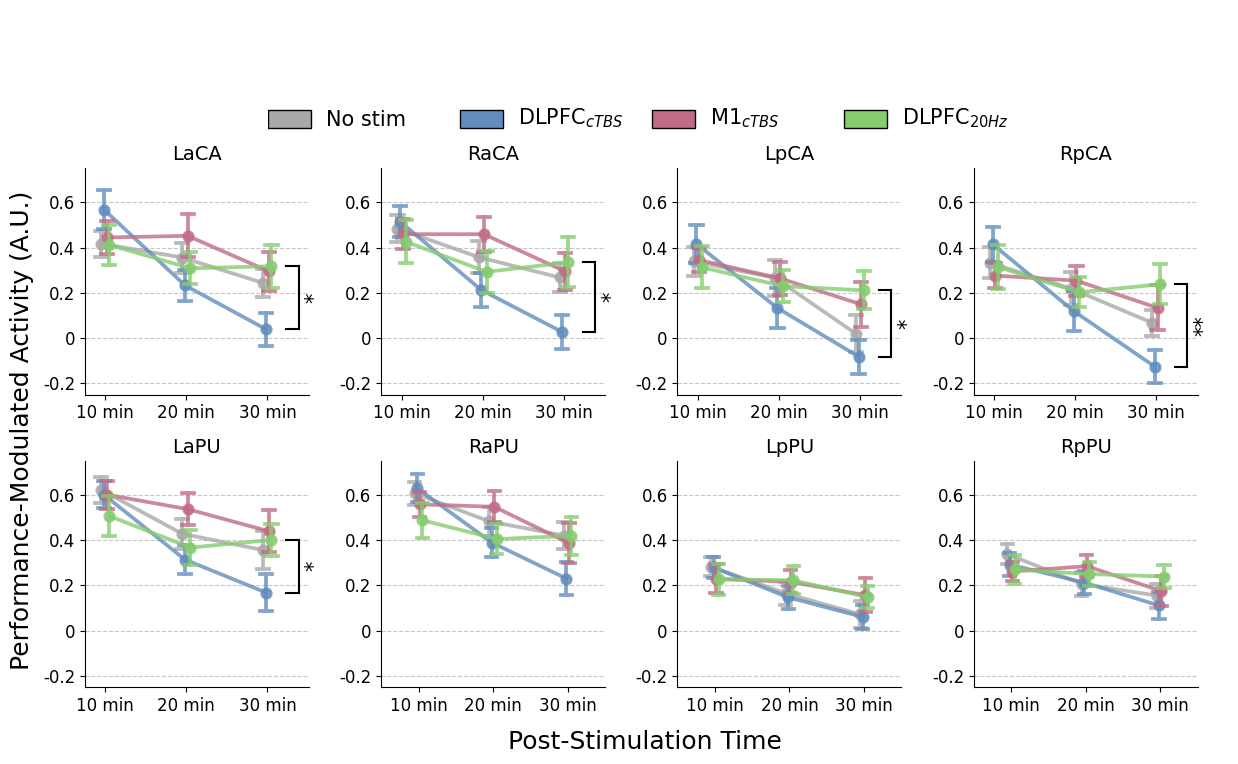

In [59]:
### legend
nax = fig.add_axes([0.20, 1, .8, 0.2])

list_color = np.round(np.linspace(0, cmap.N-1, 3)).astype(int)

for ii, group in enumerate(hue_order):
    if group == 'no_stim':
        gg = 'No stim'
    elif group == 'DLPFC_cTBS':
        gg = 'DLPFC$_{cTBS}$'
    elif group == 'M1_cTBS':
        gg = 'M1$_{cTBS}$'
    elif group == 'DLPFC_20Hz':
        gg = 'DLPFC$_{20Hz}$'
        
    rgb = cmap(ii)
    dx = 0.2*ii
    # dx = 0.25*ii
    x, y = 0 + dx, 0.02
    w, h = 0.045, 0.15
    nax.add_patch(Rectangle((x,y),w , h, facecolor=rgb, edgecolor='k'))
    nax.text(x+.06, 0, gg, fontsize=15, horizontalalignment='left', verticalalignment='bottom')
    # nax.text(x+.085, 0, gg, fontsize=15, horizontalalignment='left', verticalalignment='bottom')
    
nax.axis('off')
fig

In [60]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fig.S2.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

---

## Statistics

### 1. T-test

In [56]:
df_tmp = df[df.run.isin(['r01','r03'])]
pivot = df_tmp.pivot_table(index=['subj', 'group', 'roi'], columns='run', values='beta').reset_index(drop=False)
pivot['beta_diff'] = pivot['r03'] - pivot['r01']
pivot

run,subj,group,roi,r01,r03,beta_diff
0,GA01,no_stim,LaCA,0.538827,-0.087391,-0.626218
1,GA01,no_stim,LaPU,0.599993,-0.137885,-0.737878
2,GA01,no_stim,LpCA,0.573242,-0.625521,-1.198764
3,GA01,no_stim,LpPU,0.151185,-0.623068,-0.774253
4,GA01,no_stim,RaCA,0.612334,-0.252511,-0.864844
...,...,...,...,...,...,...
635,GP75,DLPFC_20Hz,LpPU,0.713161,0.485856,-0.227304
636,GP75,DLPFC_20Hz,RaCA,1.177611,1.086447,-0.091163
637,GP75,DLPFC_20Hz,RaPU,1.116773,0.862148,-0.254625
638,GP75,DLPFC_20Hz,RpCA,1.084892,0.616211,-0.468681


In [57]:
anterior = ['LaCA','RaCA','LaPU','RaPU']
caudate = ['LaCA','RaCA','LpCA','RpCA']
list_ = list_roi
# list_ = caudate

In [58]:
n_Bonferroni = len(list_)
# n_Bonferroni = len(anterior)
n_Bonferroni

8

In [59]:
for roi in list_:
    a = pivot[(pivot.roi==roi)&(pivot.group=='no_stim')].beta_diff
    b = pivot[(pivot.roi==roi)&(pivot.group=='DLPFC_cTBS')].beta_diff

    # Perform an independent t-test
    res = stats.ttest_ind(a, b)
    tval, pval = res
    dof = res.df
    ## Bonferroni correction
    pval_c = pval * n_Bonferroni

    print('%s: t(%d)=%.2f (%sp=%.5f; corrected %sp=%.5f)'%
        (roi,dof,tval,convert_pvalue_to_asterisks(pval),pval,convert_pvalue_to_asterisks(pval_c),pval_c)
    )

LaCA: t(45)=3.22 (**p=0.00236; corrected *p=0.01892)
RaCA: t(45)=2.55 (*p=0.01425; corrected nsp=0.11396)
LpCA: t(45)=1.49 (nsp=0.14230; corrected nsp=1.13842)
RpCA: t(45)=2.37 (*p=0.02237; corrected nsp=0.17892)
LaPU: t(45)=1.43 (nsp=0.15973; corrected nsp=1.27784)
RaPU: t(45)=2.26 (*p=0.02892; corrected nsp=0.23136)
LpPU: t(45)=0.08 (nsp=0.93820; corrected nsp=7.50559)
RpPU: t(45)=-0.03 (nsp=0.98015; corrected nsp=7.84123)


In [60]:
for roi in list_:
    a = pivot[(pivot.roi==roi)&(pivot.group=='no_stim')].beta_diff
    b = pivot[(pivot.roi==roi)&(pivot.group=='DLPFC_20Hz')].beta_diff

    # Perform an independent t-test
    res = stats.ttest_ind(a, b)
    tval, pval = res
    dof = res.df
    ## Bonferroni correction
    pval_c = pval * n_Bonferroni

    print('%s: t(%d)=%.2f (%sp=%.5f; corrected %sp=%.5f)'%
        (roi,dof,tval,convert_pvalue_to_asterisks(pval),pval,convert_pvalue_to_asterisks(pval_c),pval_c)
    )

LaCA: t(44)=-0.85 (nsp=0.39925; corrected nsp=3.19402)
RaCA: t(44)=-1.17 (nsp=0.25010; corrected nsp=2.00082)
LpCA: t(44)=-1.77 (nsp=0.08435; corrected nsp=0.67477)
RpCA: t(44)=-1.52 (nsp=0.13571; corrected nsp=1.08571)
LaPU: t(44)=-1.41 (nsp=0.16664; corrected nsp=1.33313)
RaPU: t(44)=-1.31 (nsp=0.19659; corrected nsp=1.57276)
LpPU: t(44)=-1.35 (nsp=0.18425; corrected nsp=1.47398)
RpPU: t(44)=-1.82 (nsp=0.07615; corrected nsp=0.60919)


In [61]:
for roi in list_:
    a = pivot[(pivot.roi==roi)&(pivot.group=='DLPFC_cTBS')].beta_diff
    b = pivot[(pivot.roi==roi)&(pivot.group=='DLPFC_20Hz')].beta_diff

    # Perform an independent t-test
    res = stats.ttest_ind(a, b)
    tval, pval = res
    dof = res.df
    ## Bonferroni correction
    pval_c = pval * n_Bonferroni

    print('%s: t(%d)=%.2f (%sp=%.5f; corrected %sp=%.5f)'%
        (roi,dof,tval,convert_pvalue_to_asterisks(pval),pval,convert_pvalue_to_asterisks(pval_c),pval_c)
    )

LaCA: t(31)=-3.69 (***p=0.00085; corrected **p=0.00683)
RaCA: t(31)=-3.68 (***p=0.00088; corrected **p=0.00707)
LpCA: t(31)=-3.93 (***p=0.00044; corrected **p=0.00351)
RpCA: t(31)=-4.45 (***p=0.00010; corrected ***p=0.00082)
LaPU: t(31)=-3.10 (**p=0.00409; corrected *p=0.03273)
RaPU: t(31)=-3.46 (**p=0.00160; corrected *p=0.01282)
LpPU: t(31)=-2.11 (*p=0.04316; corrected nsp=0.34525)
RpPU: t(31)=-2.28 (*p=0.02983; corrected nsp=0.23861)


## Fig. 3C_2

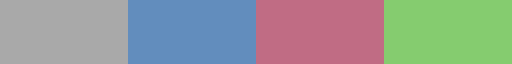

In [62]:
palette = ['#A9A9A9', '#628dbd', '#C06C84', '#85cc6f']
cmap = colors.ListedColormap(palette)
cmap

In [63]:
df_tmp = df[df.run.isin(['r01','r03'])]
pivot = df_tmp.pivot_table(index=['subj', 'group', 'roi'], columns='run', values='beta_sum').reset_index(drop=False)
pivot['beta_sum_diff'] = pivot['r03'] - pivot['r01']
pivot

run,subj,group,roi,r01,r03,beta_sum_diff
0,GA01,no_stim,LaCA,38.256683,-6.204786,-44.461469
1,GA01,no_stim,LaPU,79.799052,-18.338753,-98.137805
2,GA01,no_stim,LpCA,59.043976,-64.428706,-123.472682
3,GA01,no_stim,LpPU,19.956442,-82.244925,-102.201368
4,GA01,no_stim,RaCA,40.414029,-16.665700,-57.079729
...,...,...,...,...,...,...
635,GP75,DLPFC_20Hz,LpPU,94.137235,64.133047,-30.004189
636,GP75,DLPFC_20Hz,RaCA,77.722318,71.705534,-6.016784
637,GP75,DLPFC_20Hz,RaPU,150.764356,116.389978,-34.374378
638,GP75,DLPFC_20Hz,RpCA,118.253219,67.166992,-51.086227


LaCA
no_stim vs DLPFC_cTBS : t(45)=3.222 (*p=0.01419 corrected)
no_stim vs M1_cTBS : t(45)=-0.242 (nsp=4.85788 corrected)
no_stim vs DLPFC_20Hz : t(44)=-0.851 (nsp=2.39551 corrected)
DLPFC_cTBS vs M1_cTBS : t(32)=-2.945 (*p=0.03588 corrected)
DLPFC_cTBS vs DLPFC_20Hz : t(31)=-3.692 (**p=0.00512 corrected)
M1_cTBS vs DLPFC_20Hz : t(31)=-0.546 (nsp=3.53564 corrected)

RaCA
no_stim vs DLPFC_cTBS : t(45)=2.550 (nsp=0.08547 corrected)
no_stim vs M1_cTBS : t(45)=-0.506 (nsp=3.69000 corrected)
no_stim vs DLPFC_20Hz : t(44)=-1.165 (nsp=1.50061 corrected)
DLPFC_cTBS vs M1_cTBS : t(32)=-3.162 (*p=0.02054 corrected)
DLPFC_cTBS vs DLPFC_20Hz : t(31)=-3.679 (**p=0.00530 corrected)
M1_cTBS vs DLPFC_20Hz : t(31)=-0.728 (nsp=2.83375 corrected)

LpCA
no_stim vs DLPFC_cTBS : t(45)=1.493 (nsp=0.85381 corrected)
no_stim vs M1_cTBS : t(45)=-1.032 (nsp=1.84654 corrected)
no_stim vs DLPFC_20Hz : t(44)=-1.766 (nsp=0.50608 corrected)
DLPFC_cTBS vs M1_cTBS : t(32)=-3.075 (*p=0.02571 corrected)
DLPFC_cTBS vs DLP

/tmp/ipykernel_613283/3173417504.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(
/tmp/ipykernel_613283/3173417504.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.legend().remove()
/tmp/ipykernel_613283/3173417504.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(
/tmp/ipykernel_613283/3173417504.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.legend().remove()
/tmp/ipykernel_613283/3173417504.py:9: FutureWarning: 

no_stim vs DLPFC_cTBS : t(45)=0.078 (nsp=5.62919 corrected)
no_stim vs M1_cTBS : t(45)=-1.316 (nsp=1.16938 corrected)
no_stim vs DLPFC_20Hz : t(44)=-1.349 (nsp=1.10549 corrected)
DLPFC_cTBS vs M1_cTBS : t(32)=-1.641 (nsp=0.66345 corrected)
DLPFC_cTBS vs DLPFC_20Hz : t(31)=-2.109 (nsp=0.25894 corrected)
M1_cTBS vs DLPFC_20Hz : t(31)=0.081 (nsp=5.61549 corrected)

RpPU
no_stim vs DLPFC_cTBS : t(45)=-0.025 (nsp=5.88092 corrected)
no_stim vs M1_cTBS : t(45)=-1.101 (nsp=1.66178 corrected)
no_stim vs DLPFC_20Hz : t(44)=-1.816 (nsp=0.45689 corrected)
DLPFC_cTBS vs M1_cTBS : t(32)=-1.209 (nsp=1.41342 corrected)
DLPFC_cTBS vs DLPFC_20Hz : t(31)=-2.277 (nsp=0.17896 corrected)
M1_cTBS vs DLPFC_20Hz : t(31)=-0.895 (nsp=2.26727 corrected)



/tmp/ipykernel_613283/3173417504.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.legend().remove()
/tmp/ipykernel_613283/3173417504.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(
/tmp/ipykernel_613283/3173417504.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.legend().remove()
/tmp/ipykernel_613283/3173417504.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


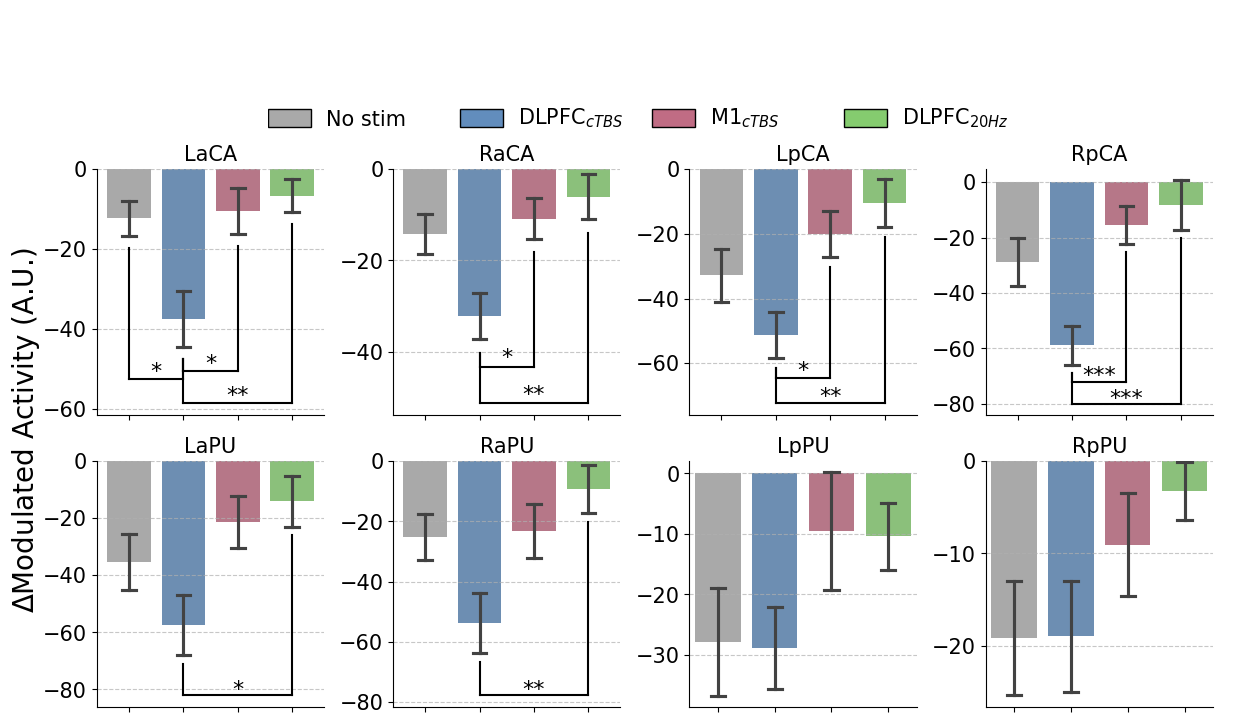

In [64]:
ncols, nrows = 4, 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols,3*nrows))
axs = np.concatenate(axs)

for kk, roi in enumerate(list_roi):
    print(roi)
    ax = axs[kk]
    g = sns.barplot(
        data=pivot[pivot.roi==roi], x='group', y='beta_sum_diff',
        order=list_group, capsize=0.25, errorbar='se',
        palette=palette,
        ax=ax
    )
    g.set_title(roi, fontsize=15, loc='center')
    g.grid(axis='y', linestyle='--', alpha=0.7)
    g.legend().remove()
    
    # g.set_ylabel(r'$\Delta$Modulated Activity (A.U.)', fontsize=18)
    g.set_ylabel('', fontsize=0)
    g.tick_params(axis='y', labelsize=15)
    
    g.set_xlabel('', fontsize=0)
    g.set_xticks(list_group)
    # g.set_xticklabels(['No stim', r'DLPFC$_{cTBS}$', r'M1$_{cTBS}$', r'DLPFC$_{20Hz}$'], fontsize=15)
    g.set_xticklabels(['', '', '', ''], fontsize=0)
    
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)
    
    for ii, g1 in enumerate(list_group):
        x1 = ii
        for jj, g2 in enumerate(list_group[ii+1:]):
            x2 = jj+1+ii
            a = pivot[(pivot.roi==roi)&(pivot.group==g1)].beta_sum_diff.astype(float)
            b = pivot[(pivot.roi==roi)&(pivot.group==g2)].beta_sum_diff.astype(float)
            res = stats.ttest_ind(a,b)
            tval, pval = res
            dof = res.df
            ## Bonferroni correction
            pval_c = pval * 6 # 4C3=6

            print('%s vs %s : t(%d)=%.3f (%sp=%.5f corrected)'%
                (g1,g2,dof,tval,convert_pvalue_to_asterisks(pval_c),pval_c)
            )
            
            if pval_c < 0.05:
                y1 = a.mean()-a.sem()-3
                y2 = b.mean()-b.sem()-3
                yBottom = min(y1,y2)-5
                if g2=='DLPFC_20Hz':
                    yBottom -= 6
                elif g2=='M1_cTBS':
                    yBottom += 2
                h = yBottom+2
                g.plot([x1, x1], [y1, yBottom], 'k-')
                g.plot([x2, x2], [y2, yBottom], 'k-')
                g.plot([x1, x2], [yBottom, yBottom], 'k-')
                g.text(
                    (x1+x2)*0.5, h, convert_pvalue_to_asterisks(pval_c),
                    ha='center', va='center', rotation=0, size=16,
                    color='k'
                )
    print('')

### legend
nax = fig.add_axes([0.2, 1, .8, 0.2])

# list_color = np.round(np.linspace(0, cmap.N-1, 4)).astype(int)

for ii, group in enumerate(list_group):
    if group == 'no_stim':
        gg = 'No stim'
    elif group == 'DLPFC_cTBS':
        gg = 'DLPFC$_{cTBS}$'
    elif group == 'M1_cTBS':
        gg = 'M1$_{cTBS}$'
    elif group == 'DLPFC_20Hz':
        gg = 'DLPFC$_{20Hz}$'
        
    rgb = cmap(ii)
    dx = 0.2*ii
    x, y = 0 + dx, 0.02
    w, h = 0.045, 0.15
    nax.add_patch(Rectangle((x,y),w , h, facecolor=rgb, edgecolor='k'))
    nax.text(x+.06, 0, gg, fontsize=15, horizontalalignment='left', verticalalignment='bottom')
    
nax.axis('off')

fig.text(-.015, 0.5, r'$\Delta$Modulated Activity (A.U.)', va='center', rotation='vertical', fontsize=20)
# fig.text(0.4, -0.02, 'Post-Stimulation Time', va='center', rotation='horizontal', fontsize=18)

fig.tight_layout()

In [65]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fig.3C_2.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

### 2. Two-way ANOVA

In [52]:
for roi in list_roi:
    print(roi)
    result_anova = pg.anova(
        data=df[(df.run=='r03')&(df.roi==roi)&(df.group.isin(hue_order))],
        dv='beta', between=['group'],
        detailed=False, effsize="np2"
    )
    print(result_anova)
    print('')

LaCA
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     60  3.099017  0.052382  0.093629

RaCA
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     60  3.356818  0.041505  0.100634

LpCA
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     60  2.414339  0.098067  0.074484

RpCA
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     60  5.268706  0.007797  0.149388

LaPU
  Source  ddof1  ddof2         F     p-unc      np2
0  group      2     60  1.774957  0.178274  0.05586

RaPU
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     60  2.247554  0.114481  0.069697

LpPU
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     60  0.520749  0.596736  0.017062

RpPU
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     60  1.054103  0.354869  0.033944



---

In [32]:
# # Define a custom function to calculate the weighted average
# def weighted_average(groupby):
#     return (groupby['beta'] * groupby['nvoxels']).sum() / groupby['nvoxels'].sum()

# # # Use groupby to group by column A and apply the custom function
# dg = df.groupby(['subj','group','run','roi_'], as_index=False).apply(weighted_average)
# dg = dg.rename(columns={None:'beta_'})
# dg

In [35]:
# Define a custom function to calculate the weighted average
wm = lambda x: np.average(x, weights=df.loc[x.index,'nvoxels'])

dg = df.groupby(
    ['subj','group','run','roi_'],
    as_index=False
).agg(
    nvoxels_=('nvoxels', 'sum'),
    beta_=('beta', wm)
)
dg

,subj,group,run,roi_,nvoxels_,beta_
0,GA01,no_stim,r01,aCA,137,0.574239
1,GA01,no_stim,r01,aPU,268,0.558998
2,GA01,no_stim,r01,pCA,212,0.535169
3,GA01,no_stim,r01,pPU,237,0.204843
4,GA01,no_stim,r02,aCA,137,0.506925
...,...,...,...,...,...,...
955,GP75,DLPFC_20Hz,r02,pPU,237,0.453272
956,GP75,DLPFC_20Hz,r03,aCA,137,0.998688
957,GP75,DLPFC_20Hz,r03,aPU,268,0.824018
958,GP75,DLPFC_20Hz,r03,pCA,212,0.578559


In [36]:
between = 'group'
within = 'run'

### Fig.3b

In [35]:
plt.rcParams['font.size'] = 12

aCA
pPU


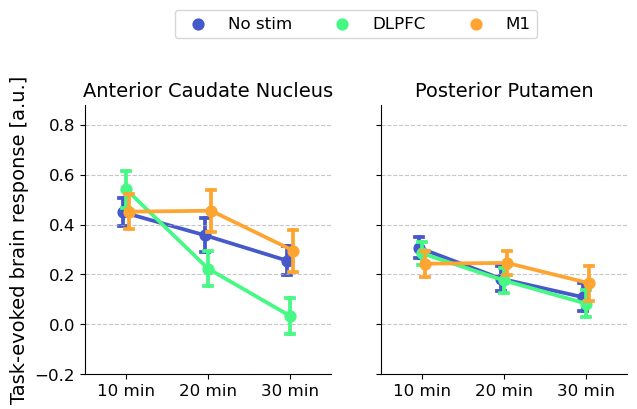

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7,3.5))

for ii, roi in enumerate(['aCA','pPU']):
    ax = axs[ii]
    print(roi)
    g = sns.pointplot(
        data=dg[dg.roi_==roi], x='run', y='beta_', hue='group',
        order=order, hue_order=hue_order, palette=palette,
        errorbar='se', capsize=0.1,
        dodge=True,
        ax=ax
    )
    g.grid(axis='y', linestyle='--', alpha=0.7)
    g.set_ylim(-0.2,0.88)
    g.legend().remove()
    g.set_xticklabels(['10 min','20 min','30 min'])
    g.set_xlabel(None)
    if ii == 0:
        g.set_title('Anterior Caudate Nucleus', fontsize=14)
        g.set_ylabel('Task-evoked brain response [a.u.]', fontsize=14)
    else:
        g.set_title('Posterior Putamen', fontsize=14)
        g.set_ylabel('')
        g.set_yticklabels('')
        g.spines['left'].set_visible(False)
        
## Setting legend
h, l = g.get_legend_handles_labels()
l_new = []
for text in l:
    a, b = text.split('_')
    if not text=='no_stim':
#         tmp = r'%s$_{%s}$'%(a.upper(),b)
        tmp = r'%s'%a.upper()
    else:
        tmp = 'No stim'
    l_new.append(tmp)
g.legend(
    h, l_new,
    bbox_to_anchor=(-0.1, 1.3), loc='center', ncol=3,
    fontsize=12
)

sns.despine()
# fig.tight_layout()

In [37]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7,3.5))

# for ii, roi in enumerate(['laCA','lpPU']):
#     ax = axs[ii]
#     print(roi)
#     g = sns.pointplot(
#         data=df[df.roi==roi], x='run', y='beta', hue='group',
#         order=order, hue_order=hue_order, palette=palette,
#         errorbar='se', capsize=0.1,
#         dodge=True,
#         ax=ax
#     )
#     g.grid(axis='y', linestyle='--', alpha=0.7)
#     g.set_ylim(-0.2,0.88)
#     g.legend().remove()
#     g.set_xticklabels(['10 min','20 min','30 min'])
#     g.set_xlabel(None)
#     if ii == 0:
#         g.set_title('Left Anterior Caudate Nucleus', fontsize=14)
#         g.set_ylabel('Task-evoked brain response [a.u.]', fontsize=14)
#     else:
#         g.set_title('Left posterior Putamen', fontsize=14)
#         g.set_ylabel('')
#         g.set_yticklabels('')
#         g.spines['left'].set_visible(False)
        
# ## Setting legend
# h, l = g.get_legend_handles_labels()
# l_new = []
# for text in l:
#     a, b = text.split('_')
#     if not text=='no_stim':
# #         tmp = r'%s$_{%s}$'%(a.upper(),b)
#         tmp = r'%s'%a.upper()
#     else:
#         tmp = 'No stim'
#     l_new.append(tmp)
# g.legend(
#     h, l_new,
#     bbox_to_anchor=(-0.1, 1.3), loc='center', ncol=3,
#     fontsize=12
# )

# sns.despine()
# # fig.tight_layout()

In [38]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fMRI.fig.3b.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = 'tight'
)

---

In [39]:
dh = dg
dh = dh.rename(columns={'roi_':'roi','beta_':'beta'})

In [40]:
dh.dtypes

subj         object
group        object
run          object
roi          object
nvoxels_      int64
beta        float64
dtype: object

#### ANOVA

In [41]:
pg.mixed_anova(
    data=dh[(dh.group!='DLPFC_20Hz')&(dh.roi=='aCA')],
    dv='beta', within=within, between=between,
    subject='subj'
).round(5)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,0.48060,2,61,0.24030,1.12167,0.33236,0.03547,NaN
1,run,2.29591,2,122,1.14796,23.01783,0.00000,0.27396,0.98
2,Interaction,0.80263,4,122,0.20066,4.02342,0.00423,0.11654,NaN


In [42]:
pg.mixed_anova(
    data=dh[(dh.group!='DLPFC_20Hz')&(dh.roi=='pPU')],
    dv='beta', within=within, between=between,
    subject='subj'
).round(5)

/home/sungbeenpark/anaconda3/envs/GP/lib/python3.9/site-packages/pingouin/parametric.py:1568: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,group,0.03452,2,61,0.01726,0.14127,0.86854,NaN,0.00461,NaN,NaN,NaN,NaN
1,run,0.89838,2,122,0.44919,14.43868,0.00000,0.00001,0.19140,0.89347,False,0.88076,0.01953
2,Interaction,0.12533,4,122,0.03133,1.00717,0.40657,NaN,0.03197,NaN,NaN,NaN,NaN


#### Post-Hoc test

In [43]:
dt = pd.DataFrame(
    columns=['roi','Contrast',between, within,'A','B','Paired','Parametric','T','dof','alternative','p-unc','BF10','none']
)
dt

,roi,Contrast,group,run,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,none


1. ROI: aCA

In [44]:
roi = 'aCA'

In [45]:
tmp = pg.pairwise_tests(
    data=dh[(dh.group!='DLPFC_20Hz')&(dh.roi==roi)],
    dv='beta', within=within, between=between,
    subject='subj',
    parametric=True, alpha=0.05,
    padjust='none', effsize='none',
    interaction=True, within_first=True
)
tmp = tmp[(tmp['p-unc']<0.05)&(tmp.run!='-')]
tmp['roi'] = roi
dt = dt.append(tmp, ignore_index=True)

/home/sungbeenpark/anaconda3/envs/GP/lib/python3.9/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()
/tmp/ipykernel_2282991/1236150177.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = dt.append(tmp, ignore_index=True)


In [46]:
tmp = pg.pairwise_tests(
    data=dh[(dh.group!='DLPFC_20Hz')&(dh.roi==roi)],
    dv='beta', within=within, between=between,
    subject='subj',
    parametric=True, alpha=0.05,
    padjust='none', effsize='none',
    interaction=True, within_first=False
)
tmp = tmp[(tmp['p-unc']<0.05)&(tmp.group!='-')]
tmp['roi'] = roi
dt = dt.append(tmp, ignore_index=True)

/home/sungbeenpark/anaconda3/envs/GP/lib/python3.9/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()
/tmp/ipykernel_2282991/1279926953.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = dt.append(tmp, ignore_index=True)
/tmp/ipykernel_2282991/1279926953.py:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  dt = dt.append(tmp, ignore_index=True)


2. ROI: pPU

In [47]:
roi = 'pPU'

In [48]:
tmp = pg.pairwise_tests(
    data=dh[(dh.group!='DLPFC_20Hz')&(dh.roi==roi)],
    dv='beta', within=within, between=between,
    subject='subj',
    parametric=True, alpha=0.05,
    padjust='none', effsize='none',
    interaction=True, within_first=True
)
tmp = tmp[(tmp['p-unc']<0.05)&(tmp.run!='-')]
tmp['roi'] = roi
dt = dt.append(tmp, ignore_index=True)

/home/sungbeenpark/anaconda3/envs/GP/lib/python3.9/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()
/tmp/ipykernel_2282991/1236150177.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = dt.append(tmp, ignore_index=True)
/tmp/ipykernel_2282991/1236150177.py:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  dt = dt.append(tmp, ignore_index=True)


In [49]:
tmp = pg.pairwise_tests(
    data=dh[(dh.group!='DLPFC_20Hz')&(dh.roi==roi)],
    dv='beta', within=within, between=between,
    subject='subj',
    parametric=True, alpha=0.05,
    padjust='none', effsize='none',
    interaction=True, within_first=False
)
tmp = tmp[(tmp['p-unc']<0.05)&(tmp.group!='-')]
tmp['roi'] = roi
dt = dt.append(tmp, ignore_index=True)
dt = dt.replace(np.nan,'-')

/home/sungbeenpark/anaconda3/envs/GP/lib/python3.9/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()
/tmp/ipykernel_2282991/292840334.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = dt.append(tmp, ignore_index=True)
/tmp/ipykernel_2282991/292840334.py:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  dt = dt.append(tmp, ignore_index=True)


In [50]:
dt

,roi,Contrast,group,run,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,none
0,aCA,run * group,-,r02,DLPFC_cTBS,M1_cTBS,False,True,-2.134159,32.00000,two-sided,0.040590,1.802,-0.732010
1,aCA,run * group,-,r03,DLPFC_cTBS,M1_cTBS,False,True,-2.374876,32.00000,two-sided,0.023717,2.65,-0.814576
2,aCA,run * group,-,r03,DLPFC_cTBS,no_stim,False,True,-2.377369,35.85749,two-sided,0.022893,2.711,-0.704228
3,aCA,group * run,DLPFC_cTBS,-,r01,r02,True,True,3.489557,16.00000,two-sided,0.003030,14.633,1.075144
4,aCA,group * run,DLPFC_cTBS,-,r01,r03,True,True,5.912193,16.00000,two-sided,0.000022,1096.724,1.689998
5,aCA,group * run,DLPFC_cTBS,-,r02,r03,True,True,3.081654,16.00000,two-sided,0.007149,7.103,0.648983
6,aCA,group * run,M1_cTBS,-,r01,r03,True,True,2.167120,16.00000,two-sided,0.045660,1.58,0.494753
7,aCA,group * run,M1_cTBS,-,r02,r03,True,True,2.357882,16.00000,two-sided,0.031441,2.119,0.466387
8,aCA,group * run,no_stim,-,r01,r03,True,True,3.277842,29.00000,two-sided,0.002718,13.79,0.611282
9,pPU,group * run,DLPFC_cTBS,-,r01,r03,True,True,3.971751,16.00000,two-sided,0.001095,34.965,0.965834


---

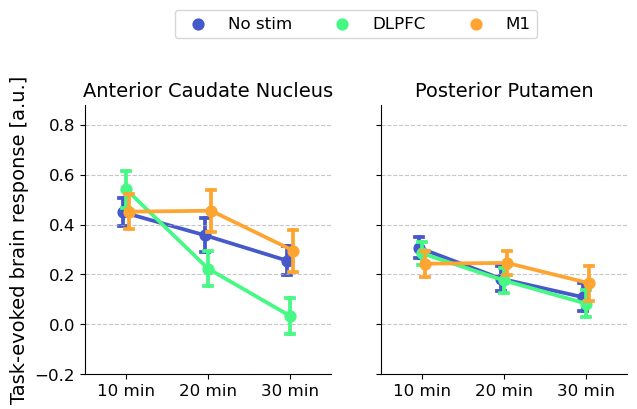

In [51]:
fig

In [52]:
for ii, roi in enumerate(['aCA','pPU']):
    ax = axs[ii]
    for jj, run in enumerate(['r01','r02','r03']):
        # pg.welch_anova(
        tmp = pg.anova(
            data=dh[(dh.group!='DLPFC_20Hz')&(dh.roi==roi)&(dh.run==run)],
            dv='beta', between=between,
            detailed=False
        )
        print(tmp)
        if tmp['p-unc'].values <0.05:
            print(roi, run)

  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     61  0.577127  0.564546  0.018571
  Source  ddof1  ddof2        F     p-unc       np2
0  group      2     61  1.95862  0.149823  0.060342
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     61  3.427823  0.038832  0.101033
aCA r03
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     61  0.476233  0.623408  0.015374
  Source  ddof1  ddof2         F     p-unc      np2
0  group      2     61  0.468866  0.627948  0.01514
  Source  ddof1  ddof2         F     p-unc       np2
0  group      2     61  0.381942  0.684155  0.012368


---

dict_keys([('aCA', 1), ('aCA', 2), ('aCA', 3), ('aCA', 4), ('aCA', 5), ('aCA', 6), ('aCA', 7), ('aCA', 8), ('aCA', 9), ('aCA', 11), ('aCA', 12), ('aCA', 13), ('aCA', 14), ('aCA', 15), ('aCA', 16), ('aCA', 17), ('aCA', 18), ('aCA', 19), ('aCA', 21), ('aCA', 22), ('aCA', 23), ('aCA', 24), ('aCA', 25), ('aCA', 26), ('aCA', 27), ('aCA', 28), ('aCA', 29), ('pPU', 1), ('pPU', 2), ('pPU', 3), ('pPU', 4), ('pPU', 5), ('pPU', 6), ('pPU', 7), ('pPU', 8), ('pPU', 9), ('pPU', 11), ('pPU', 12), ('pPU', 13), ('pPU', 14), ('pPU', 15), ('pPU', 16), ('pPU', 17), ('pPU', 18), ('pPU', 19), ('pPU', 21), ('pPU', 22), ('pPU', 23), ('pPU', 24), ('pPU', 25), ('pPU', 26), ('pPU', 27), ('pPU', 28), ('pPU', 29)])


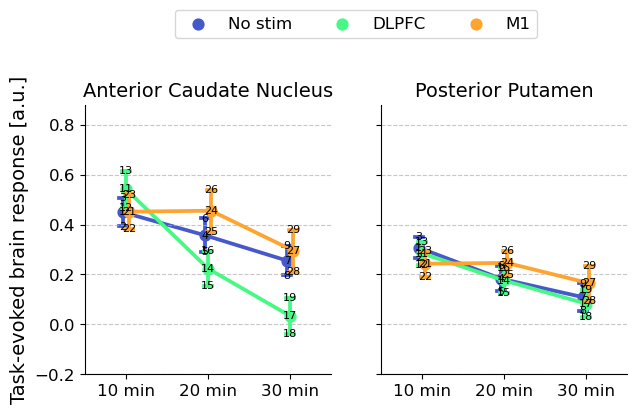

In [53]:
bboxes = {}
for ii, roi in enumerate(['aCA', 'pPU']):
    ax = axs[ii]
    idx = -1
    for child in ax.get_children():
        if not type(child) is lines.Line2D:
            continue
        idx+=1
        if idx in [0,10,20]:
            continue
        bbox = child.get_bbox()
        ax.text(
            x=(bbox.x0+bbox.x1)*0.5, y=(bbox.y0+bbox.y1)*0.5,
            s=idx, fontsize=8,
            va='center', ha='center'
        )
        bboxes[(roi,idx)] = bbox
print(bboxes.keys())
fig

In [54]:
tmp = np.delete(np.arange(len(hue_order)*len(order)*3 + 3), [0,10,20])
indices = {}
cnt = 0
for h in hue_order:
    for l in ['mid','bottom','top']:
        for o in order:
            indices[(h,l,o)] = tmp[cnt]
            cnt+=1
indices

{('no_stim', 'mid', 'r01'): 1,
 ('no_stim', 'mid', 'r02'): 2,
 ('no_stim', 'mid', 'r03'): 3,
 ('no_stim', 'bottom', 'r01'): 4,
 ('no_stim', 'bottom', 'r02'): 5,
 ('no_stim', 'bottom', 'r03'): 6,
 ('no_stim', 'top', 'r01'): 7,
 ('no_stim', 'top', 'r02'): 8,
 ('no_stim', 'top', 'r03'): 9,
 ('DLPFC_cTBS', 'mid', 'r01'): 11,
 ('DLPFC_cTBS', 'mid', 'r02'): 12,
 ('DLPFC_cTBS', 'mid', 'r03'): 13,
 ('DLPFC_cTBS', 'bottom', 'r01'): 14,
 ('DLPFC_cTBS', 'bottom', 'r02'): 15,
 ('DLPFC_cTBS', 'bottom', 'r03'): 16,
 ('DLPFC_cTBS', 'top', 'r01'): 17,
 ('DLPFC_cTBS', 'top', 'r02'): 18,
 ('DLPFC_cTBS', 'top', 'r03'): 19,
 ('M1_cTBS', 'mid', 'r01'): 21,
 ('M1_cTBS', 'mid', 'r02'): 22,
 ('M1_cTBS', 'mid', 'r03'): 23,
 ('M1_cTBS', 'bottom', 'r01'): 24,
 ('M1_cTBS', 'bottom', 'r02'): 25,
 ('M1_cTBS', 'bottom', 'r03'): 26,
 ('M1_cTBS', 'top', 'r01'): 27,
 ('M1_cTBS', 'top', 'r02'): 28,
 ('M1_cTBS', 'top', 'r03'): 29}

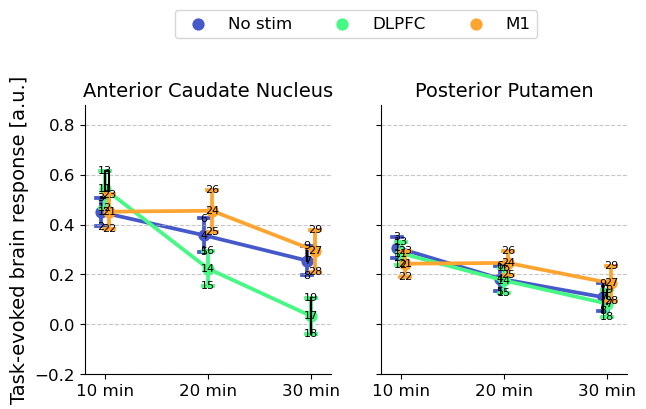

In [55]:
dx = 0
dy = 0

for ii, row in dt.iterrows():
    if row.roi == 'aCA':
        ax = axs[0]
    elif row.roi == 'pPU':
        ax = axs[1]
    else:
        break

    if row.run == '-':
        ## within (paired)
        keyA = (row.group, 'top', row.A)
        keyB = (row.group, 'top', row.B)
    elif row.group == '-':
        ## between
        keyA = (row.A, 'mid', row.run)
        keyB = (row.B, 'mid', row.run)
    else:
        break
    
    bboxA = bboxes[(row.roi, indices[keyA])]
    bboxB = bboxes[(row.roi, indices[keyB])]
    xA = (bboxA.x0+bboxA.x1)*0.5
    xB = (bboxB.x0+bboxB.x1)*0.5
    yA = (bboxA.y0+bboxA.y1)*0.5
    yB = (bboxB.y0+bboxB.y1)*0.5

    if row.run == '-':
        y = max(yA,yB)
        ax.plot([xA,xA],[yA,y], color='k', linestyle='-')
        ax.plot([xB,xB],[yB,y], color='k', linestyle='-')
        ax.plot([xA,xB],[y,y], color='k', linestyle='-')
    elif row.group == '-':
        x = max(xA,xB)
        ax.plot([xA,x],[yA,yA], color='k', linestyle='-')
        ax.plot([xB,x],[yB,yB], color='k', linestyle='-')
        ax.plot([x,x],[yA,yB], color='k', linestyle='-')
fig

In [56]:
# ## xy0_xy
# for key, xy in xy0_xy.items():
#     (a, g, r) = key

#     if a == 'ax0':
#         ax = axs[0]
#     elif a == 'ax1':
#         ax = axs[1]
    
#     ax.text(
#         x = xy[0], y = xy[1],
#         s = '=', fontsize = 12,
#         va = 'center', ha = 'center'
#     )
# fig

---

In [32]:
# for xx, group in enumerate(list_group):
#     dx = 0.04*(-1+xx)
#     for ii, r1 in enumerate(list_run):
#         x1 = ii + dx
#         a = df[(df.roi==roi)&(df.group==group)&(df.run==r1)].beta
#         y1 = a.mean()+a.sem() + dy
#         for jj, r2 in enumerate(list_run[ii+1:]):
#             x2 = jj+ii+1 + dx
#             b = df[(df.roi==roi)&(df.group==group)&(df.run==r2)].beta
#             y2 = b.mean()+b.sem() + dy
#             tval, pval = stats.ttest_rel(
#                 a=a.astype(float), b=b.astype(float),
#                 alternative='two-sided'
#             )
#             if pval < 0.05:
#                 print('%s (%s vs. %s): %.5f (%s)'%(group,r1,r2,pval,convert_pvalue_to_asterisks(pval)))
#                 if (r1=='r01')&(r2=='r03'):
#                     if roi=='laCA':
#                         y = 0.81
#                     elif roi=='lpPU':
#                         y = 0.48
#                     dy = -0.025
#                     ro = 0
#                     va = 'bottom'
#                 elif (r1=='r01'):
#                     if roi=='laCA':
#                         y = 0.72
#                     elif roi=='lpPU':
#                         y = 0.39
#                     dy = -0.025
#                     ro = 0
#                     va = 'bottom'
#                 elif (r1=='r02'):
#                     y = -0.1
#                     dy = 0.025
#                     ro = 180
#                     va = 'top'
#                 g.plot([x1,x1],[y+dy,y], color=palette[xx], linestyle='-')
#                 g.plot([x2,x2],[y+dy,y], color=palette[xx], linestyle='-')
#                 g.plot([x1,x2],[y,y], color=palette[xx], linestyle='-')
#                 g.text(
#                     0.5*(x1+x2), y, convert_pvalue_to_asterisks(pval),
#                     ha='center', va=va, rotation=ro, size=11
#                 )
# print('')

# fig

In [27]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fMRI.fig.3b.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = 'tight'
)

---

### Fig.4

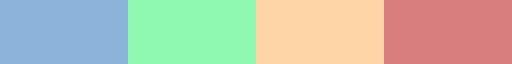

In [37]:
# tmp = cm.terrain(np.linspace(0.2, 0.8, 4))
# palette = [colors.to_rgba(rgb, alpha=1) for rgb in tmp]

# tmp = cm.turbo(np.linspace(0.1,1.0,4))
# palette = [colors.rgb2hex(rgb, keep_alpha=False) for rgb in tmp]
palette = ['#8cb3d9','#8ff8b1','#fed5a6','#d87e7e']

colors.ListedColormap(palette)

r03


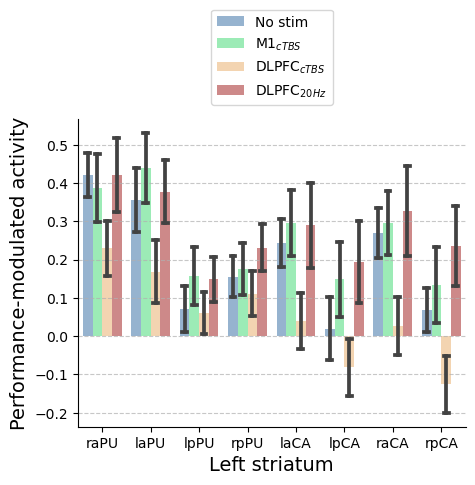

In [38]:
print(run)

fig, ax = plt.subplots(figsize=(5,4))

dg = df[df.run==run]

g = sns.barplot(
    data=dg,
    x='roi', y='beta', hue='group',
    hue_order=('no_stim', 'M1_cTBS', 'DLPFC_cTBS', 'DLPFC_20Hz'),
#     order=['left_anterior','left_posterior'],
    palette=palette,
    errorbar='se', capsize=0.1,
    ax=ax
)
# list_label = g.get_xticklabels()
# g.set_xticklabels(['Anterior','Posterior'], fontsize=13, rotation=0)
g.set_xlabel('Left striatum', fontsize=14)
g.set_ylabel('Performance-modulated activity', fontsize=14)
g.grid(axis='y', linestyle='--', alpha=0.7)
g.legend(bbox_to_anchor=(0.5, 1.2), loc='center', ncol=1)

list_group = g.get_legend_handles_labels()[-1]
for ii, text in enumerate(list_group):
    if ii==0:
        text_new = 'No stim'
    else:
        a, b = text.split('_')
        text_new = r'%s$_{%s}$'%(a.upper(),b)
    g.legend_.texts[ii].set_text(text_new)

# ## Bounding box
# bbox = g.get_position()
# rect = (0.4, 0.6, 0.55, 0.3) # (x0, y0, w, h)
# ax_insert = fig.add_axes(rect)
# nilearn.plotting.plot_roi(
#     img_roi
#     , display_mode='ortho', draw_cross=False
# #     , cut_coords=[0, 40, 10]
#     , axes=ax_insert
# )

sns.despine()

In [34]:
list_pair = []
for aa in list_group:
    for bb in list_label:
        list_pair.append((aa,bb))

list_rect = []
list_line = []
for child in g.get_children():
    if type(child) is patches.Rectangle:
        list_rect.append(child)
    elif type(child) is lines.Line2D:
        list_line.append(child)
list_rect = list_rect[:8]
list_line = list_line[:3*8]

dict_rect = {}
for pair, rect in zip(list_pair, list_rect):
    print(pair, rect)
    dict_rect[pair] = pair

dict_line = {}
for ii, pair in enumerate(list_pair):
    for jj, line in enumerate(list_line[ii*3:(ii+1)*3]):
        kk = 'mid' if jj==0 else ('bottom' if jj==1 else ('top' if jj==2 else 'invalid'))
#         print((*(pair), kk), line)
        dict_line[(*(pair), kk)] = line

del list_pair, list_rect, list_line

('no_stim', 'laST') Rectangle(xy=(-0.4, 0), width=0.2, height=0.316564, angle=0)
('no_stim', 'lpST') Rectangle(xy=(0.6, 0), width=0.2, height=0.049152, angle=0)
('M1_cTBS', 'laST') Rectangle(xy=(-0.2, 0), width=0.2, height=0.389095, angle=0)
('M1_cTBS', 'lpST') Rectangle(xy=(0.8, 0), width=0.2, height=0.153408, angle=0)
('DLPFC_cTBS', 'laST') Rectangle(xy=(2.77556e-17, 0), width=0.2, height=0.123386, angle=0)
('DLPFC_cTBS', 'lpST') Rectangle(xy=(1, 0), width=0.2, height=-0.00174429, angle=0)
('DLPFC_20Hz', 'laST') Rectangle(xy=(0.2, 0), width=0.2, height=0.346694, angle=0)
('DLPFC_20Hz', 'lpST') Rectangle(xy=(1.2, 0), width=0.2, height=0.168443, angle=0)


In [42]:
for roi in dg.roi.unique():
    print(roi)
    for ii, g1 in enumerate(list_group):
        for g2 in list_group[ii+1:]:
#             kk = 'less' if 'DLPFC' in g1 else ('greater' if 'DLPFC' in g2 else 'two-sided')
            kk = 'two-sided'

            a = dg[(dg.group==g1)&(dg.roi==roi)].beta
            b = dg[(dg.group==g2)&(dg.roi==roi)].beta
            print('%s (n=%d) vs %s (n=%d) (%s):   '%(g1,len(a),g2,len(b),kk), end='\t')

            tval, pval = stats.ranksums(
                a.values.astype(float), b.values.astype(float),
                alternative = kk
            )
            print("%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))
    print('')

laST
no_stim (n=30) vs M1_cTBS (n=17) (two-sided):   	0.4384 (ns)
no_stim (n=30) vs DLPFC_cTBS (n=17) (two-sided):   	0.0354 (*)
no_stim (n=30) vs DLPFC_20Hz (n=11) (two-sided):   	0.7240 (ns)
M1_cTBS (n=17) vs DLPFC_cTBS (n=17) (two-sided):   	0.0263 (*)
M1_cTBS (n=17) vs DLPFC_20Hz (n=11) (two-sided):   	0.8324 (ns)
DLPFC_cTBS (n=17) vs DLPFC_20Hz (n=11) (two-sided):   	0.0701 (ns)

lpST
no_stim (n=30) vs M1_cTBS (n=17) (two-sided):   	0.5649 (ns)
no_stim (n=30) vs DLPFC_cTBS (n=17) (two-sided):   	0.1840 (ns)
no_stim (n=30) vs DLPFC_20Hz (n=11) (two-sided):   	0.4269 (ns)
M1_cTBS (n=17) vs DLPFC_cTBS (n=17) (two-sided):   	0.0761 (ns)
M1_cTBS (n=17) vs DLPFC_20Hz (n=11) (two-sided):   	0.9812 (ns)
DLPFC_cTBS (n=17) vs DLPFC_20Hz (n=11) (two-sided):   	0.0777 (ns)

{'laST': 2, 'lpST': 0}


laST
no_stim (90) vs M1_cTBS (51) (two-sided):
0.3322 (ns)
no_stim (90) vs DLPFC_cTBS (51) (greater):
0.0552 (ns)
no_stim (90) vs DLPFC_20Hz (33) (greater):
0.0827 (ns)
M1_cTBS (51) vs DLPFC_cTBS (51) (greater):
0.0137 (*)
M1_cTBS (51) vs DLPFC_20Hz (33) (greater):
0.0208 (*)
DLPFC_cTBS (51) vs DLPFC_20Hz (33) (less):
0.5128 (ns)

lpST
no_stim (90) vs M1_cTBS (51) (two-sided):
0.6308 (ns)
no_stim (90) vs DLPFC_cTBS (51) (greater):
0.2329 (ns)
no_stim (90) vs DLPFC_20Hz (33) (greater):
0.4298 (ns)
M1_cTBS (51) vs DLPFC_cTBS (51) (greater):
0.1369 (ns)
M1_cTBS (51) vs DLPFC_20Hz (33) (greater):
0.2866 (ns)
DLPFC_cTBS (51) vs DLPFC_20Hz (33) (less):
0.3351 (ns)



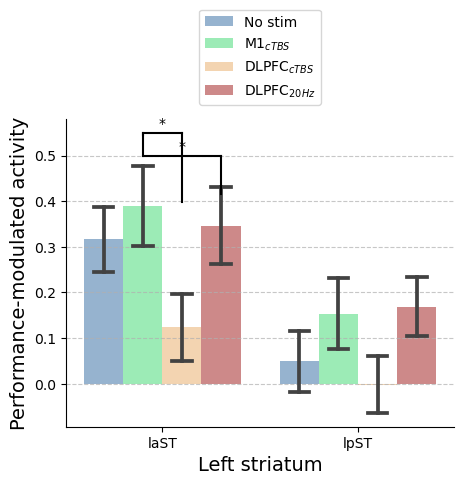

In [38]:
yApart = 0.02

for roi in df.roi.unique():
    print(roi)
    tmp = [0.5+0.05*ii for ii in range(cnt[roi])]
    for ii, g1 in enumerate(list_group):
        for g2 in list_group[ii+1:]:
            kk = 'less' if 'DLPFC' in g1 else ('greater' if 'DLPFC' in g2 else 'two-sided')

            a = df[(df.group==g1)&(df.roi==roi)].beta
            b = df[(df.group==g2)&(df.roi==roi)].beta
            print('%s (%d) vs %s (%d) (%s):'%(g1,len(a),g2,len(b),kk))

            tval, pval = stats.ranksums(
                a.values.astype(float), b.values.astype(float)
                , alternative = kk
            )
            print("%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))
            
            if pval < 0.05:
                cnt[roi] -= 1
                [x10,y10],[x11,y11] = np.array(dict_rect[(g1,roi)].get_bbox())
                x1 = (x10+x11)*0.5
                [x20,y20],[x21,y21] = np.array(dict_rect[(g2,roi)].get_bbox())
                x2 = (x20+x21)*0.5
                
                yUEdge = tmp[cnt[roi]]
                g.plot([x1, x1], [a.mean()+(a.sem()+yApart), yUEdge], 'k-')
                g.plot([x2, x2], [b.mean()+(b.sem()+yApart), yUEdge], 'k-')
                g.plot([x1, x2], [yUEdge, yUEdge], 'k-')
                g.text(
                    (x1+x2)*0.5, yUEdge+(0.02), convert_pvalue_to_asterisks(pval)
                    , ha='center', va='center', rotation=0, size=10
                )
    print('')
fig

In [33]:
for ii, group in enumerate(list_group):
    width = dict_rect[(group,'left_anterior')].get_width()
    h1 = dict_rect[(group,'left_anterior')].get_height()
    h2 = dict_rect[(group,'left_posterior')].get_height()
    height = h1 - h2
    x2 = dict_rect[(group,'left_posterior')].get_x()
    xy = (x2, h2)
    color = (*palette[ii][:3], 0.5)
    g.add_patch(patches.Rectangle(
        xy=xy, width=width, height=height
        , facecolor=color, edgecolor=None
#         , hatch='o'
    ))
fig

KeyError: ('no_stim', 'left_anterior')

In [24]:
cnt['diff'] = 0
r1, r2 = 'anterior', 'posterior'
print("%s vs. %s"%(r1, r2))
list_ = g.get_legend_handles_labels()[-1]
for ii, g1 in enumerate(list_):
    for g2 in list_[ii+1:]:
        print('%s vs %s'%(g1,g2))
        kk = 'greater' if 'M1' in g1 else ('less' if 'M1' in g2 else 'two-sided')
        
        a = df[(df.group==g1)&(df.roi=='left_anterior')].beta
        b = df[(df.group==g1)&(df.roi=='left_posterior')].beta

        c = df[(df.group==g2)&(df.roi=='left_anterior')].beta
        d = df[(df.group==g2)&(df.roi=='left_posterior')].beta

        tval, pval = stats.ttest_ind(
            (a-b).values.astype(float), (c-d).values.astype(float)
            , alternative = kk
        )
        print("%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))
        tval, pval = stats.ranksums(
            (a-b).values.astype(float), (c-d).values.astype(float)
            , alternative = kk
        )
        print("%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))
        if pval < 0.05:
            cnt['diff'] += 1
cnt

anterior vs. posterior
no_stim vs M1_cTBS
0.5302 (ns)
0.3451 (ns)
no_stim vs DLPFC_cTBS
0.0019 (**)
0.0018 (**)
no_stim vs DLPFC_20Hz
0.5731 (ns)
0.3464 (ns)
M1_cTBS vs DLPFC_cTBS
0.0101 (*)
0.0069 (**)
M1_cTBS vs DLPFC_20Hz
0.3535 (ns)
0.2330 (ns)
DLPFC_cTBS vs DLPFC_20Hz
0.1121 (ns)
0.2126 (ns)


{'left_anterior': 0, 'left_posterior': 0, 'diff': 2}

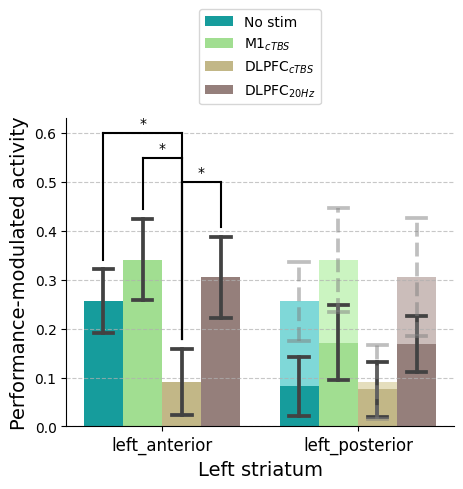

In [25]:
dict_ = {}
for legend in g.get_legend_handles_labels()[-1]:
    a = df[(df.group==legend)&(df.roi=='left_anterior')].beta
    b = df[(df.group==legend)&(df.roi=='left_posterior')].beta
    mean = (a-b).mean()
    std = (a-b).std()
    dy = std*0.5

    ref_bottom = dict_line[(legend, 'left_posterior', 'bottom')].get_bbox()
    x0 = ref_bottom.x0
    x1 = ref_bottom.x1
    xm = (x0+x1)*0.5

    ref_mid = dict_line[(legend, 'left_posterior', 'mid')].get_bbox()
    h = (ref_mid.y0+ref_mid.y1)*0.5 + mean

    width = dict_line[(legend, 'left_posterior', 'mid')].get_linewidth()

    mid = [[xm,xm],[h-dy,h+dy]]
    g.add_line(lines.Line2D(mid[0], mid[1], color='gray', alpha=0.5, linewidth=width, linestyle='--'))
    bottom = [[x0,x1],[h-dy,h-dy]]
    g.add_line(lines.Line2D(bottom[0], bottom[1], color='gray', alpha=0.5, linewidth=width, linestyle='-'))
    top = [[x0,x1],[h+dy,h+dy]]
    dict_[legend] = top
    g.add_line(lines.Line2D(top[0], top[1], color='gray', alpha=0.5, linewidth=width, linestyle='-'))

fig

In [ ]:
## t test
yApart = 0.02
roi = 'diff'
for ii, g1 in enumerate(list_group)
    for jj, g2 in enumerate(list_group[ii+1]):
        a = df[(df.group==g1)&(df.roi=='left_anterior')].beta
        b = df[(df.group==g1)&(df.roi=='left_posterior')].beta

        c = df[(df.group==g2)&(df.roi=='left_anterior')].beta
        d = df[(df.group==g2)&(df.roi=='left_posterior')].beta

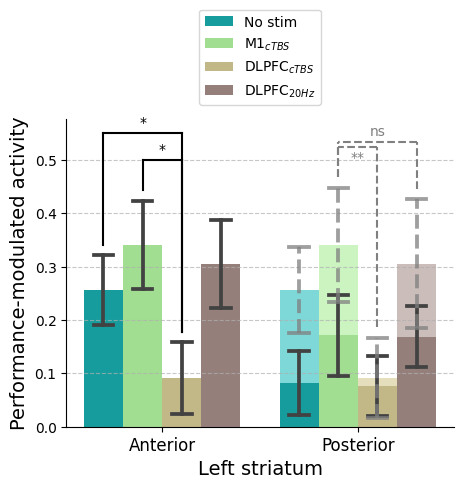

In [42]:
## t test
N = 4
yApart = [-0.02, 0.02]

g2 = 'M1_cTBS'
for ii, g1 in enumerate(['DLPFC_cTBS', 'DLPFC_20Hz']):
    a = df[(df.group==g1)&(df.roi=='left_anterior')].beta
    b = df[(df.group==g1)&(df.roi=='left_posterior')].beta

    c = df[(df.group==g2)&(df.roi=='left_anterior')].beta
    d = df[(df.group==g2)&(df.roi=='left_posterior')].beta
    tval, pval = stats.ranksums(
        (a-b).values.astype(float), (c-d).values.astype(float)
        , alternative='less'
    )

    x1 = (dict_[g1][0][0]+dict_[g1][0][1])*0.5
    x2 = (dict_[g2][0][0]+dict_[g2][0][1])*0.5
    
    yUEdge = tmp[ii]
    g.plot([x1, x1], [dict_[g1][1][0]+0.02, yUEdge], color='gray', linestyle='--')
    g.plot([x2, x2], [dict_[g2][1][0]+0.02, yUEdge], color='gray', linestyle='--')
    g.plot([x1, x2], [yUEdge, yUEdge], color='gray', linestyle='--')
    g.text(
        (x1+x2)*0.5, yUEdge+yApart[ii], convert_pvalue_to_asterisks(pval)
        , ha='center', va='center', rotation=0, size=10
        , color='gray'
    )

g.set_xticklabels(['Anterior', 'Posterior'], fontsize=12)

fig

/home/sungbeenpark/.local/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:572: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  img = new_img_like(roi_img, data, affine=roi_img.affine)
/tmp/ipykernel_450850/807858559.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


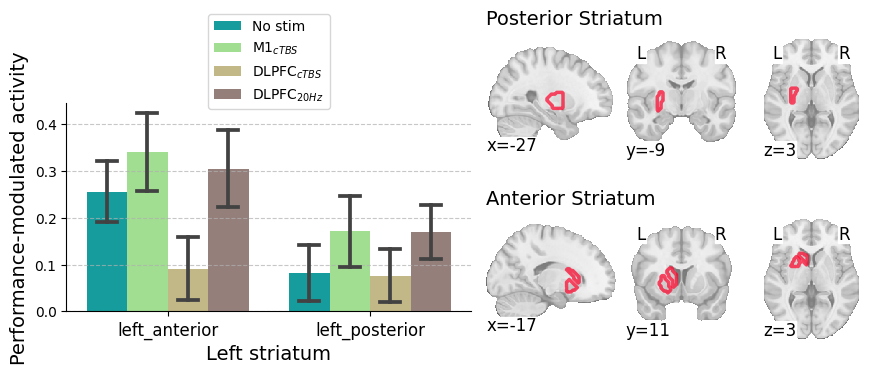

In [35]:
## add rois
w, h = 0.26, 0.3
dy = 0.1
rects = [
    [
        (1, 0+dy ,w, h),
        (1+w, 0+dy ,w, h),
        (1+2*w, 0+dy ,w, h)
    ],
    [
        (1, 0.45+dy ,w, h),
        (1+w, 0.45+dy ,w, h),
        (1+2*w, 0.45+dy ,w, h)
    ]
]
coord = [[-17,11,3], [-27,-9,3]]
for ii, (roi, img) in enumerate(imgs.items()):
    for jj, axis in enumerate(['x','y','z']):
        ax_insert = fig.add_axes(rect=rects[ii][jj])
        plotting.plot_roi(
            img, black_bg=False
            , display_mode=axis
            , cut_coords=[coord[ii][jj]], draw_cross=False
            , view_type='contours', linewidths=2.5
            , cmap='gist_rainbow'
            , axes=ax_insert
        )

for ii, roi in enumerate(['Posterior','Anterior']):
    fig.text(
        x=1, y=0.9 - 0.45*ii
        , s='%s Striatum'%roi
        , fontsize=14
        , horizontalalignment='left'
        , verticalalignment='center'
    )

fig.tight_layout()
fig

In [25]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fMRI.fig_3-b.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = 'tight'
)

---